[An online version of this notebook is available here](https://nbviewer.jupyter.org/github/lorenzodenisi/Heart-Failure-Clinical-Records/blob/master/Heart%20Failures.ipynb) <br>

# Heart Failure clinical records 


Heart failure occurs when the heart is not able to pump enough blood to the body.<br>
HF are only a subgroup of all the **cardiovascular diseases** that comprehend also coronary heart diseases (heart attacks), cerebrovascular diseases (strokes) and other pathologies that altogether kill every year  approximately **17 million people** around the world.<br>



Machine learning applied to medical records can be useful to  predict the survival of a patient, highlighting patterns and even ranking the features to understand which are **risk factors**, possibly undetectable by doctors.<br>
In this notebook the analisys will be done starting from an **EDA** to understand the dataset and applying some **preprocessing** to be able to learn properly from it.<br>
Then will follow a number of **machine learning models** trained on the preprocessed dataset, aiming to predict the **survival** of patients that suffered HF.<br>
The results are presented at the end of the notebook. ([click here to go to the end](#Results_and_conclusions))

<a id='index'></a>
### Index
*  [Exploratory Data analisys](#Exploratory_data_analisys)

    * [Imports](#Imports)
    * [Dataset](#Dataset)
    * [Feature distributions](#Feature_distributions)
    * [Standardization](#Standardization)
    * [Correlation matrix](#Correlation_matrix)
    * [Normality Assumptions](#normality_assumptions)
    * [Validate the models](#validate_the_models)
    * [Feature selection](#Feature_selection)
        * [Mutual information](#Mutual_information)
        * [Chi-squared test](#Chi_squared_test)
        * [KFold case](#KFold_case)
    * [Class imbalance](#Class_imbalance)
        * [Random oversampling](#oversampling)
        * [Smote](#Smote)
        * [Class-weight parameter](#Class_weight)
        
    
*  [Classification models](#Classification_models)
    * [Decision tree](#Decision_tree)
    * [Random forest](#Random_forest)
    * [Linear regression](#Linear_regression)
    * [Logistic regression](#Logistic_regression)
    * [Support vector machine](#Support_vector_machine)
        * [Linear kernel](#Linear_kernel)
        * [Polynomial and RBF kernels](#Polynomial_and_RBF_kernels)
        * [Polynomial kernel](#Polynomial_kernel)
        * [RBF kernel](#RBF_kernel)
    * [K nearest neighbors](#K_nearest_neighbors)
        * [weights="original"](#weights_original)
        * [weights="distance"](#weights_distance)
    * [Naive bayes](#Naive_bayes)
        * [Kernel density estimation](#Kernel_density_estimation)
        * [Naive bayes with KDE and bernoulli (Flexible bayes)](#naive_bayes_with_KDE_and_bernoulli)
        * [Gaussian Naive Bayes](#Gaussian_naive_bayes)
    
    
*  [Results and conclusions](#Results_and_conclusions)
*  [References](#references)

<a id='Exploratory_data_analisys'></a>

# **Exploratory data analisys** <a style="text-decoration:none" href="#index">⤴</a>

<a id='Imports'></a>
## Imports <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>

Here are listed the main libraries used:
* **Numpy**: standard library for math operations
* **Scipy**: used to compute test statistics and distributions
* **Pandas**: used to manipulate data inside dataframes and for basic computations
* **Sklearn**: used to apply different ML models to the data
* **Pyplot** to plot visualizations
* **Seaborn** built on top of pyplot (nicer visualizations)

Other libraries:
* **random**: used to generate random numbers
* **HTML and matplotlib.animation**: used for the animations

<a id='Dataset'></a>
##  Dataset <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>

**Heart failure clinical records Data Set** contains the medical records of 299 patients who had heart failure.<br>
The dataset contains 11 clinical features (some of them are binary, others are numerical), the *follow-up* period and the label `DEATH_EVENT` that indicates whether or not the patient has died.<br>
We can find some features strictly related to medical aspects like levels of enzymes, sodium, creatinine and platelets in the blood and others that are more common like age, sex or smoking.

The dataset is collected in 2015 at the Allied Hospital in Faisalabad (Punjab, Pakistan)

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.animation as animation
from IPython.core.display import HTML

In [ ]:
hf = pd.read_csv("../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv")

| Feature  | Explanation | Measurement | Range |
| :------------- | :------------- | :------------- | :------------- |
| `age`   | Age of the patient | Years | (40, ..., 95) |
| `anaemia`  | Decrease of red blood cells or hemoglobin<br> (haematocrit levels were lower than 36%)  | Boolean  |  0, 1 |
| `creatinine_phosphokinase` | Level of the CPK enzyme in the blood | mcg/L | (23, ..., 7861) |
| `diabetes` | If the patient has diabetes | Boolean | 0, 1 |
| `ejection_fraction` | Percentage of blood leaving the heart<br> at each contraction | Percentage | (14, ..., 80) |
| `high_blood_pressure`  | If a patient has hypertension | Boolean | 0, 1 |
| `platelets` | Platelets in the blood | kiloplatelets/mL | (25.01, ..., 850.00) |
| `serum_creatinine` | Level of creatinine in the blood | mg/dL | (0.50, ..., 9.40) |
| `serum_sodium` | Level of sodium in the blood |  mEq/L | 114, ..., 148 |
| `sex` | Woman or man | Binary | 0, 1 |
| `smoking` | If the patient smokes | Boolean | 0, 1 |
| `time` | Follow-up period | Days | (4, ..., 285) |
| `DEATH_EVENT` | If the patient died during the follow-up period |  Boolean | 0, 1 |

To be consistent with the feature description let's represent the `platelets` as kiloplatelets/mL

In [ ]:
hf.platelets = hf.platelets/1000

Let's take a look to the dataset

In [ ]:
hf.head()

For brevity `creatinine_phosphokinase` will be renamed `CPK`.

In [ ]:
hf["CPK"] = hf["creatinine_phosphokinase"]
hf = hf.drop("creatinine_phosphokinase", axis=1)

In [ ]:
# PALETTE

from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

meshPalette = []
meshPalette_rev = []
nCol = 50

for i in range(nCol):
    meshPalette.append(colorFader("#71706E", "#990303", i/nCol))
    meshPalette_rev.append(colorFader("#990303","#9C9999", i/nCol))

cm = LinearSegmentedColormap.from_list("cmap_name", meshPalette, N=nCol)
cm_rev = LinearSegmentedColormap.from_list("cmap_name", meshPalette_rev, N=nCol)

#sns.palplot(meshPalette)
#sns.palplot(["#990303", "#9C9999", "#71706E", "#292323", "#FFFFFF"]);

<a id='Feature_distributions'></a>
## Feature distributions <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>
We can see how features are distributed according to label.

In [ ]:
numerical_features = ["age", "CPK", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
categorical_features = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]

Firstly we plot the **numerical** features (omitting `time` because is not used in the prediction).<br>
In this case we plot the kernel density estimation with a **kdeplot** to better see the distribution along with the **boxplot**.

In [ ]:
plt.figure(figsize=(18, 27))

for i, col in enumerate(numerical_features):
    plt.subplot(6, 4, i*2+1)
    plt.subplots_adjust(hspace =.25, wspace=.3)
    
    plt.grid(True)
    plt.title(col)
    sns.kdeplot(hf.loc[hf["DEATH_EVENT"]==0, col], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
    sns.kdeplot(hf.loc[hf["DEATH_EVENT"]==1, col], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
    plt.subplot(6, 4, i*2+2) 
    sns.boxplot(y = col, data = hf, x="DEATH_EVENT", palette = ["#990303", "#9C9999"])   

As we can see already from the unnormalized distribution plot of the features, the most informative ones seem to be `ejection_fraction` and `serum_creatinine`.<br>
This is confirmed by the fact that in the original paper by Chicco and Jurman [[1](#references)] the analisys has been conducted taking into account only these two features.

Here are reported the **categorical** features

In [ ]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.subplots_adjust(hspace =.5, wspace=.3)
    sns.countplot(data=hf, x=col, hue="DEATH_EVENT", palette = ["#990303", "#9C9999"], alpha=0.8, edgecolor="k", linewidth=1)

<a id='Standardization'></a>
## Standardization <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>
One important step is standardization for numerical features that is performed via the standard `sklearn` function, removing the mean and scaling to unit variance.

\begin{align}
{z = \frac{(x−\bar{x})}{\hat{\sigma}}}
\end{align}

where $\bar{x}$ is the mean of the training samples and ${\hat{\sigma}}$ is the sample standard deviation.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import matplotlib.image as mpimg
from matplotlib import gridspec

hf_norm = hf.copy()

for i, col in enumerate(numerical_features):
    hf_norm[[col]] = StandardScaler(with_mean=True, with_std=True).fit_transform(hf_norm[[col]])
    
plt.figure(figsize=(16, 4))
gs  = gridspec.GridSpec(1, 5, width_ratios=[1, 1 ,0.1, 1, 1])
plt.subplot(gs[0])   
plt.grid(True)
plt.title("ejection fraction")
sns.kdeplot(hf.loc[hf["DEATH_EVENT"]==0, "ejection_fraction"], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
sns.kdeplot(hf.loc[hf["DEATH_EVENT"]==1, "ejection_fraction"], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
plt.subplot(gs[1]) 
sns.boxplot(y = "ejection_fraction", data = hf, x="DEATH_EVENT", palette = ["#990303", "#9C9999"])  
plt.subplot(gs[2])
plt.imshow(mpimg.imread("../input/heart-failure-clinical-records-images/right_arrow.png"))
plt.axis('off')
plt.subplot(gs[3])
plt.grid(True)
plt.title("ejection fraction")
sns.kdeplot(hf_norm.loc[hf["DEATH_EVENT"]==0, "ejection_fraction"], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
sns.kdeplot(hf_norm.loc[hf["DEATH_EVENT"]==1, "ejection_fraction"], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
plt.subplot(gs[4])
sns.boxplot(y = "ejection_fraction", data = hf_norm, x="DEATH_EVENT", palette = ["#990303", "#9C9999"]);  
plt.tight_layout()

<a id='Correlation_matrix'></a>
## Correlation matrix <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>

To see how features are correlated is useful to look at the correlation matrix that is a matrix in which are showed the correlation values of each couple of features according to the **Pearson's correlation coefficient**:

${\displaystyle \rho _{X_1,X_2}={\frac {\operatorname {cov} (X_1,X_2)}{\sigma _{X_1}\sigma _{X_2}}}}$ 

Where $cov$ stands for the covariance measure:

${\displaystyle \operatorname {cov} (X_1,X_2)=\operatorname {E}{{\big [}(X_1-\operatorname {E} [X_1])(X_2-\operatorname {E} [X_2]){\big ]}},}$

That is computed for every pair of features ${X_1}$ and ${X_2}$

In [ ]:
all_features = categorical_features.copy()
all_features.extend(numerical_features)

In [ ]:
plt.figure(figsize=(8, 7))
sns.heatmap(hf_norm[all_features].corr(method='pearson'), vmin=-1, vmax=1, cmap='viridis', annot=True, fmt='.2f');

From the heatmap we can see that in general, features are quite uncorrelated with the exception of `sex` and `smoking` that seems to be slightly positively correlated. <br>
As we will see during feature selection, this is not a problem since one of the two will be dropped.

<a id='normality_assumptions'></a>

## Normality assumptions <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>

Speaking of the numerical features, it's interesting to notice whether or not they come from a normal distribution.<br>
This could be helpful for some models ([Gaussian Naive Bayes](#Gaussian_naive_bayes)) in which is assumed normality conditional to the class.<br>
To test it, a **Shapiro-Wilk test** is performed on all numerical features.<br>
The test statistic is:

\begin{align}
{
W = \frac
{\Big( \sum_{i=1}^{n} a_i x_{(i)}  \Big)^2}
{\sum_{i=1}^{n} \big( x_i - \bar{x} \big)^2}
}
\end{align}

where $x_{(i)}$ is the i-th smallest number in the sample, $\bar{x}$ is the sample mean and $a_i$ are coefficients derived from a normal distributions.

The **null hypothesis** is that the samples are taken from a normal distribution, so with a sufficiently low value of the p-value we can consider the features as **not normal**.

In [ ]:
from scipy.stats import shapiro

#sw_df = pd.DataFrame(columns=["DEATH_EVENT=0", "DEATH_EVENT=1", "Both"])
index = [(feat, "statistic") for feat in numerical_features]
index.extend([(feat, "p-value") for feat in numerical_features])

index = pd.MultiIndex.from_tuples(index)

sw_df = pd.DataFrame(index=index,  columns = ["Both Classes", "DEATH_EVENT=0", "DEATH_EVENT=1"])

for feat in numerical_features:
    x = hf_norm[feat]
    stat, p = shapiro(x)
    
    sw_df["Both Classes"].loc[(feat, "statistic")] = stat
    sw_df["Both Classes"].loc[(feat, "p-value")] = p
    
    x = hf_norm.loc[hf["DEATH_EVENT"]==0, feat]
    stat, p = shapiro(x)
    sw_df["DEATH_EVENT=0"].loc[(feat, "statistic")] = stat
    sw_df["DEATH_EVENT=0"].loc[(feat, "p-value")] = p
    
    x = hf_norm.loc[hf["DEATH_EVENT"]==1, feat]
    stat, p = shapiro(x)
    sw_df["DEATH_EVENT=1"].loc[(feat, "statistic")] = stat
    sw_df["DEATH_EVENT=1"].loc[(feat, "p-value")] = p
    
sw_df = sw_df.unstack()

In [ ]:
pd.set_option('display.float_format', '{:.3g}'.format)
sw_df

In this case, applying an hypotethical alpha value equal to 0.05, all the numerical features could be considered non normal.<br>
This holds for the samples conditional on the class but also considering all of them, as we can see from the table.

<a id='validate_the_models'></a>

## Validate the models <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>
To validate and test our models we can have different approaches.<br>
The first one is **holdout**, that consists in dividing the dataset into subsets dedicated to training, validation and test.
This is useful when we have lots of data.<br>
In this case we have 299 records so the same subset is used both for validation and testing.<br>
Another approach is **K-Fold** that consists in diving the dataset into K parts with an equal number of samples, using K-1 for training and the last one as validation.<br> 
This is done K times and each part is used as validation exactly once.<br>
Then the results are combined (averaged).<br>

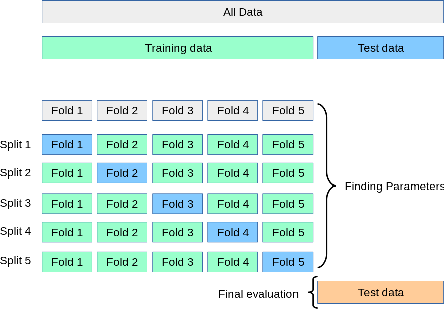

When the number on samples for each part is 1, the method is called **leave-1-out**.

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [ ]:
train_ratio = 0.75
val_ratio = 0.25

ho_train_df, ho_val_df = train_test_split(hf_norm, train_size = train_ratio, random_state=42)
unnorm_ho_train_df, unnorm_ho_val_df = train_test_split(hf, train_size = train_ratio, random_state=42)

print("Holdout split:")
print(f"Train samples: {len(ho_train_df)}")
print(f"Validation/Test samples: {len(ho_val_df)}")

<a id='Feature_selection'></a>
## Feature selection <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>
<a id='Mutual_information'></a>
### Mutual information

Mutual information can be useful when it's needed to assess the dependence of a feature with respect to the target.<br>
**MI** is always > 0  and higher values indicate stronger dependence.<br>
Formally:

\begin{align}
{I(X;Y) =\sum_{y \in Y}\sum_{x \in X}p_{X, Y}(x, y)log\Bigg( \frac {p_{X, Y}(x, y)}{p_X(x)p_Y(y)} \Bigg)}
\end{align}

\begin{align}
{I(X;Y) =\int_{y}\int_{x}p_{X, Y}(x, y)log\Bigg( \frac {p_{X, Y}(x, y)}{p_X(x)p_Y(y)} \Bigg)dx dy}
\end{align}


In this case the mutual information is estimated for each feature with respect to the class label `DEATH_EVENT`.<br>
Mutual information is estimated with the function `mutual_info_classif` from `sklearn` that, according to the  [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html), exploits entropy estimation from k-nearest neighbors distances. 

In [ ]:
from sklearn.feature_selection import mutual_info_classif

    
MI = (mutual_info_classif(ho_train_df[all_features],
                             ho_train_df["DEATH_EVENT"], n_neighbors=20,
                             discrete_features=[True, True, True, True, True, False, False, False, False, False, False],
                             random_state=42))

plt.figure(figsize=(5.4, 4))
plt.barh(y=all_features, width=MI, color="#990303")
plt.title("Mutual information w.r.t. DEATH_EVENT (whole training set)");
plt.xlabel("Mutual information")
plt.gca().xaxis.grid(True, linestyle=':');
plt.tight_layout();

<a id='Chi_squared_test'></a>
### Chi-squared test

For the categorical features we can further test the dependence w.r.t. the target with a **chi-squared test**.<br>
A lower value of the statistic means a stronger independence.

Chi-squared test is performed starting from the contingency table, for instance:

In [ ]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

print("Observed")
ctable = pd.crosstab(ho_train_df["anaemia"], ho_train_df["DEATH_EVENT"])
ctable.columns = ["DEATH_EVENT=0", "DEATH_EVENT=1"]
ctable.index = ["anaemia=0", "anaemia=1"]
ctable.loc["Total"] = ctable.sum()
ctable["Total"] = ctable.sum(axis=1)
ctable

that indicates how samples are distributed among these two features. 

The **null hypothesis** is that `anaemia` and `DEATH_EVENT` are independent, so we compute the expected values considering them as under **the null hypothesis**, so:

\begin{align}
{P(anaemia=0, DEATH\_EVENT=0) = P(anaemia=0)\times P(DEATH\_EVENT=0) = \frac{128 \times 159}{224 \times 224} = 0.406}
\end{align}


\begin{align}
{E(anaemia=0, DEATH\_EVENT=0) = P(anaemia=0, DEATH\_EVENT=0) \times N = 0.406 \times 224 = 90.9}
\end{align}

In [ ]:
print("Expected")
contingency_table = pd.crosstab(ho_train_df["anaemia"], ho_train_df["DEATH_EVENT"])
stat, p, dof, expected = chi2_contingency(contingency_table)
expected = pd.DataFrame(expected)
expected.columns = ["DEATH_EVENT=0", "DEATH_EVENT=1"]
expected.index = ["anaemia=0", "anaemia=1"]
expected

Then we know that:

\begin{align}
{X^2 = \sum_{i=1}^k \frac{(o_i - e_i)^2}{e_i}}
\end{align}

where $o_i$ is the observed value and $e_i$ is the expected value of the i-th combination of features.<br>
As the number of samples goes to infinity, $X^2$ tends to a $\chi^2$ distribution with (columns-1)\*(rows-1) degrees of freedom (so in this case 1).<br>

In the `scipy` implementation, the statistic is further corrected with **Yates correction** for continuity that, according to the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html) (and [definition](https://en.wikipedia.org/wiki/Chi-squared_test#Yates's_correction_for_continuity)), consists in subtracting 0.5 from the absolute difference, in the numerator.<br>
In this way, the statistic for `anaemia` is 0.617.
<br>

Now that we have the statistic we could compare it with a **chi2 distribution** with those given degrees of freedom, fixing an alpha value and keeping only the features that produce a lower p-value (rejected). 



In [ ]:
def chi2_test(df, feat1, feat2):

    contingency_table = pd.crosstab(df[feat1], df[feat2])
    
    stat, p, dof, expected = chi2_contingency(contingency_table)
    prob = 0.95 # alpha=0.05
    critical = chi2.ppf(prob, dof)
    #print('alpha=%.3f, critical_value=%.3f,\nstat=%.3f' % (1 - prob, critical, stat))

    # interpret p-value
    alpha = 1.0 - prob
    
    return stat, p

In [ ]:
stats = []
p_values = []

for feat in categorical_features:
        
    stat, p = chi2_test(ho_train_df, feat, "DEATH_EVENT")
    stats.append(stat)
    p_values.append(p)        

fig, axes = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(8.5, 4)
axes[0].barh(y=categorical_features, width=stats, color="#990303", label="test statistic", height=0.5)
axes[0].set_title("Chi squared test statistics")

axes[1].barh(y=categorical_features, width=p_values, color="#9C9999", label="p-value", height=0.5)
axes[1].set_title("Chi squared test p-values")

axes[0].xaxis.grid(True, linestyle=':');
axes[1].xaxis.grid(True, linestyle=':');

axes[0].legend(loc=1)
axes[1].legend(loc=4)

fig.subplots_adjust(wspace=0.06)
plt.tight_layout()

#### Results
From the results we can say that `smoking`, `high_blood_pressure`, `diabetes` and `platelets` can be easily dropped.<br>
Altough `sex`and `anaemia` produce still very low values of the statistic, they are kept.
(In this way we can see how models handle a mix of continouos and binary features)

In [ ]:
kfold_train_df, kfold_val_df = ho_train_df.copy(), ho_val_df.copy()

all_features = ['anaemia', 'sex', 'age', 'CPK',
                'ejection_fraction', 'serum_creatinine', 'serum_sodium']

#ho_train_df, ho_val_df = ho_train_df[all_features+["DEATH_EVENT"]], ho_val_df[all_features+["DEATH_EVENT"]]
#unnorm_ho_train_df, unnorm_ho_val_df = unnorm_ho_train_df[all_features+["DEATH_EVENT"]], unnorm_ho_val_df[all_features+["DEATH_EVENT"]]

<a id='KFold_case'></a>
### KFold case

When kfold crossvalidation is done, feature selection needs to be performed inside every iteration, in fact, performing it before would mean considering the whole training set and this can lead to an overestimation of the accuracy during cross validation.<br>
In this case, feature selection consists in dropping features that have a very low mutual information and chi squared statistic so it's possible to evaluate those for each iteration of KFold.

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(12.5, 2.5))

print("Mutual information with respect to DEATH_EVENT (5 folds)")
for i, (train_idx, val_idx) in enumerate(kf.split(kfold_train_df, kfold_train_df["DEATH_EVENT"])):
    MI=(mutual_info_classif(kfold_train_df.iloc[train_idx][categorical_features+numerical_features],
                             kfold_train_df.iloc[train_idx]["DEATH_EVENT"], n_neighbors=20,
                             discrete_features=[True, True, True, True, True, False, False, False, False, False, False],
                             random_state=42))
    plt.subplot(1, 5, i+1)
    plt.title(f"Iteration {i+1}")
    plt.barh(y=['anaemia', 'diabetes', 'h.b.p.','sex', 'smoking', 'age', 'CPK', 'e.f.', 'platelets',
         's.c.', 's.s.'], width=MI, color="#990303", label="test statistic")
    
plt.tight_layout()  

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plt.figure(figsize=(12.5, 2.5))
print("Chi squared test statistics (5 folds)")
for i, (train_idx, val_idx) in enumerate(kf.split(kfold_train_df, kfold_train_df["DEATH_EVENT"])):
    stats = []
    p_values = []

    for feat in categorical_features:

        stat, p = chi2_test(kfold_train_df.iloc[train_idx], feat, "DEATH_EVENT")
        stats.append(stat)
        p_values.append(p)
    
    plt.subplot(1, 5, i+1)
    plt.title(f"Iteration {i+1}")
    plt.barh(y=['anaemia', 'diabetes', 'h.b.p.', 'sex', 'smoking'], width=stats, color="#990303", label="test statistic")
plt.tight_layout()

We can see that for the mutual information, the vast majority of the cases the features are kept or dropped analogously to the holdout feature election so we stick with the original feature selection removing `platelets`. <br>

For the chi-squared test the results are quite different, so it's decided to keep the top 2 for each iteration.

|Iteration|Feature 1| Feature 2|
|:---:|---|---|
|**Iteration 1**|anaemia|diabetes|
|**Iteration 2**|sex|smoking|
|**Iteration 3**|anaemia|sex|
|**Iteration 4**|anaemia|smoking|
|**Iteration 5**|sex|smoking|

In [ ]:
numerical_features = ['age', 'CPK', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']
all_features_kfold = [
    ["anaemia", "diabetes"]+numerical_features,
    ["sex", "smoking"]+numerical_features,
    ["anaemia", "sex"]+numerical_features,
    ["anaemia", "smoking"]+numerical_features,
    ["sex", "smoking"]+numerical_features,
]

<a id='Class_imbalance'></a>
## Class imbalance <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>

One thing to take into account is the possible class imbalance.<br>

In [ ]:
plt.figure(figsize=(3, 3))
plt.pie(hf["DEATH_EVENT"].value_counts(),
        labels = ["alive", "dead"],
        colors = ["#990303", "#9C9999"], 
        wedgeprops={'edgecolor':'black', 'linewidth': 2}, 
        autopct = lambda y: str(round(y))+"%",
        startangle=90);

As we can see, even if not so strong, there is a class imbalance.<br>
This can leads to biased results that can be noticed by measures such as `recall`, `precision` or `f1`.<br>
To handle class inbalance it's possible to *re-balance* the dataset with different techniques.

<a id='oversampling'></a>
### Random oversampling

Random oversampling is a resample technique that consists in taking the under-represented class samples and sampling new samples from them until the classes are balanced.<br>
During training, random oversampling needs to be done after the subdivision into train, validation and test to avoid **data leakage**.<br>
The idea is that, not being able to sample more samples from the true distribution, we sample them from the empirical distribution coming from the samples that we already have.

In [ ]:
n_to_sample = len(ho_train_df[ho_train_df.DEATH_EVENT==0]) - len(ho_train_df[ho_train_df.DEATH_EVENT==1])
new_samples = ho_train_df[ho_train_df.DEATH_EVENT==1].sample(n_to_sample, replace=True, random_state=42)

ho_train_df_rs = ho_train_df.append(new_samples)

new_samples = unnorm_ho_train_df[unnorm_ho_train_df.DEATH_EVENT==1].sample(n_to_sample, replace=True, random_state=42)
unnorm_ho_train_df_rs = unnorm_ho_train_df.append(new_samples)

Here we can see the distribution of `ejection_fraction` for only under-represented class samples before and after oversampling. (the line is a kde)

In [ ]:
nbins = 10
plt.figure(figsize = (8, 4))

plt.subplot(1, 2, 1)
plt.ylim(0, 1)
plt.title("Distribution for class 1 before oversampling")
sns.distplot(ho_train_df[ho_train_df.DEATH_EVENT==1].ejection_fraction, bins=nbins)
plt.subplot(1, 2, 2)
plt.ylim(0, 1)
plt.title("Distribution for class 1 after oversampling")
sns.distplot(ho_train_df_rs[ho_train_df_rs.DEATH_EVENT==1].ejection_fraction, bins=nbins);
plt.tight_layout()

<a id='Smote'></a>
### Smote  

Synthetic Minority Oversampling Technique or SMOTE is a useful technique used to deal with unbalanced datasets.
It consists in taking for each sample of the minority class the k-nearest neighbours an then synthesize new samples starting from the sample and one of the nearest neighbours (chosen randomly)

To show how SMOTE works let's plot the samples according to `ejection_fraction` and `serum_creatinine`.
In the visualization below, SMOTE is performed on the whole dataset while then, when we use it during classification, we perform it only on training samples (as stated for random oversampling, using it on the whole dataset leads to data leakage).<br>The same happens in the kfold case in which resampling methods are applied inside each iteration and not before.
<br>
<br>
A jittering is added on the x axis to better see the distribution.

In [ ]:
def rand_jitter(arr):
    np.random.seed(42)
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [ ]:
norm = np.linalg.norm
import random
from random import sample 

def SMOTE(data, sampling_rate, n_neigh, random_state=42):
    random.seed(random_state)
    new_samples = []
    
    if sampling_rate==0:
        return
    
    if sampling_rate>n_neigh: return      
    data = data.reset_index(drop=True)

    n_samples = data.count()[0]

    for i in range(n_samples):
        dists = []
        for j in range(n_samples):
            if i==j: continue
            dists.append((j, norm(data.loc[i]-data.loc[j])))    
        
        topk = sorted(dists, key=lambda s: s[1])[:n_neigh]
        neighs = sample(topk, sampling_rate)

        for neigh in neighs:
            alpha = random.random()
            new_samples.append(data.loc[i] + alpha * (data.loc[neigh[0]]-data.loc[i]))
            
    return new_samples

My implementation of **SMOTE** is based on the original paper by N. V. Chawla *et al.* [[2]](#references).<br>

We can see how it works when the sample rate is higher. <br>
In this case the imbalance is not so strong so, just with a sample rate of 1 we obtain a good balance between classes.

In [ ]:
%matplotlib notebook
plt.ioff()
fig, ax = plt.subplots(1, 1);
%matplotlib inline 
plt.ion()

In [ ]:
fig.set_size_inches(4, 4);
fig.set_dpi(100)

def animate_func(i):
    new_samples = SMOTE(hf[hf["DEATH_EVENT"]==1][["ejection_fraction", "serum_creatinine"]], sampling_rate = i, n_neigh = 20)
    sm_hf = hf.copy()

    if new_samples:
        sm_hf = hf.append(new_samples)
        
    sm_hf["DEATH_EVENT"].fillna(1, inplace=True)
    
    ax.clear();

    ax.set_ylim(0, 17.5);
    ax.set_xlim(10, 90);
    
    ax.scatter((sm_hf[sm_hf["DEATH_EVENT"]==1]["ejection_fraction"]),
            sm_hf[sm_hf["DEATH_EVENT"]==1]["serum_creatinine"], s=5, label="DEAD", color="#71706E", alpha=1)
    ax.scatter(rand_jitter(sm_hf[sm_hf["DEATH_EVENT"]==0]["ejection_fraction"]),
            sm_hf[sm_hf["DEATH_EVENT"]==0]["serum_creatinine"], s=5, label="ALIVE", color="#990303", alpha=1)
    ax.legend()
    
    ax.set_xlabel("ejection_fraction")
    ax.set_ylabel("serum_creatinine")
    ax.set_title(f"Sampling rate: {i}, ALIVE = {sm_hf[sm_hf.DEATH_EVENT==0].count()[3]}, DEAD = {sm_hf[sm_hf.DEATH_EVENT==1].count()[3]}")

    return [fig]
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = 10,
                               interval = 100, # in ms
                               );

HTML(anim.to_jshtml())

In [ ]:
n_to_sample = len(ho_train_df[ho_train_df.DEATH_EVENT==0]) - len(ho_train_df[ho_train_df.DEATH_EVENT==1])
new_samples = SMOTE(ho_train_df[ho_train_df["DEATH_EVENT"]==1][all_features],
                    sampling_rate = 1, n_neigh = 50)

# categorical attributes need to be fixed
for s in new_samples:
    s["anaemia"] = np.round(s["anaemia"])
    s["sex"] = np.round(s["sex"])

ho_train_df_sm = ho_train_df.append(new_samples)
ho_train_df_sm["DEATH_EVENT"].fillna(1, inplace=True)


new_samples = SMOTE(unnorm_ho_train_df[unnorm_ho_train_df["DEATH_EVENT"]==1][all_features],
                    sampling_rate = 1, n_neigh = 50)

# categorical attributes need to be fixed
for s in new_samples:
    s["anaemia"] = np.round(s["anaemia"])
    s["sex"] = np.round(s["sex"])

unnorm_ho_train_df_sm = unnorm_ho_train_df.append(new_samples)
unnorm_ho_train_df_sm["DEATH_EVENT"].fillna(1, inplace=True)

In [ ]:
nbins = 10
plt.figure(figsize = (8, 4))

plt.subplot(1, 2, 1)
plt.ylim(0, 1)
plt.title("Distribution for class 1 before SMOTE")
sns.distplot(ho_train_df[ho_train_df.DEATH_EVENT==1].ejection_fraction, bins=nbins)
plt.subplot(1, 2, 2)
plt.ylim(0, 1)
plt.title("Distribution for class 1 after SMOTE")
sns.distplot(ho_train_df_sm[ho_train_df_sm.DEATH_EVENT==1].ejection_fraction, bins=nbins)
plt.tight_layout();

<a id='Class_weight'></a>
### Class-weight parameter

Another way to handle the class imbalance is class weighting.<br>
This is a parameter present in many models that allows to weight samples during training according to the imbalance.<br>
The configuration tested is `class-weight="balanced"` that according to the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) sets the weights in this way:<br>

${w_i = \frac {N} {m\times n_i}}$
where ${N}$ is the total number of samples, ${m}$ is the number of classes and ***${n_i}$*** is the number of samples belonging to class i.

In our case the weights will be:

In [ ]:
w = len(ho_train_df) / (2 * np.bincount(ho_train_df.DEATH_EVENT))
print(f"class 0: {w[0]} \nclass 1: {w[1]}")

In [ ]:
# KFOLD

class KFold():
    
    # caching smote results 
    smote_folds = None
    smote_labels = None
    
    def __init__(self, all_features_kfold, random_state=42):
        self.smote_folds = []
        self.smote_labels = []
        self.features = all_features_kfold
        
        self.kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    def fit_predict(self, model, X, y, threshold = None, resampling = None, cached = False):
        acc, rec, pre, f1 = 0, 0, 0, 0
        
        if resampling=="SMOTE" and not cached:
            self.smote_folds = []
            self.smote_labels = []
        
        for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
           
            X_fold = X[self.features[i]] # for each fold we have different features
        
            X_train, X_val = X_fold.iloc[train_idx], X_fold.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            if resampling=="oversampling":
                n_to_sample = len(X_train[y_train==0]) - len(X_train[y_train==1])
                new_samples = X_train[y_train==1].sample(n_to_sample, replace=True, random_state=42)
                
                X_train = X_train.append(new_samples)
                y_train = y_train.append(pd.Series([1]*len(new_samples)))
                
                X_train = X_train.reset_index(drop=True)
                y_train = y_train.reset_index(drop=True)

            if resampling=="SMOTE": 
                if not cached or len(self.smote_folds)<5 or len(self.smote_labels)<5:
                    n_to_sample = len(X_train[y_train==0]) - len(X_train[y_train==1])
                    new_samples = SMOTE(X_train[y_train==1], sampling_rate = 1, n_neigh = 50)

                    # categorical attributes need to be fixed
                    for s in new_samples:
                        if "anaemia" in  s.index:
                            s["anaemia"] = np.round(s["anaemia"])
                        if "high_blood_pressure" in s.index:
                            s["high_blood_pressure"] = np.round(s["high_blood_pressure"])
                        if "sex" in  s.index:
                            s["sex"] = np.round(s["sex"])
                        if "smoking" in  s.index:
                            s["smoking"] = np.round(s["smoking"])
                        if "diabetes" in  s.index:
                            s["diabetes"] = np.round(s["diabetes"])
                                            
                    X_train = X_train.append(new_samples, ignore_index=True)
                    y_train = y_train.append(pd.Series([1]*len(new_samples)))
                    
                    X_train = X_train.reset_index(drop=True)
                    y_train = y_train.reset_index(drop=True)
                    
                    # cache smoted folds
                    self.smote_folds.append(X_train)
                    self.smote_labels.append(y_train)
                    
                else:
                    # use cached folds
                    X_train = self.smote_folds[i]
                    y_train = self.smote_labels[i]

            model.fit(X_train, y_train)
            preds = model.predict(X_val)

            if threshold:
                preds[preds>=threshold] = 1
                preds[preds<threshold] = 0

            acc += accuracy_score(y_val, preds)
            pre += precision_score(y_val, preds)
            rec += recall_score(y_val, preds)
            f1 += f1_score(y_val, preds)

        acc /= 5
        pre /= 5
        rec /= 5
        f1 /= 5
        return acc, pre, rec, f1

In [ ]:
# initialize kfold object
kfold = KFold(all_features_kfold, random_state=42)

<a id='Classification_models'></a>
# Classification models <a style="text-decoration:none" href="#index">⤴</a>

Now will follow a series of different models used to perform classification of the `DEATH_EVENT`

* [Decision tree](#Decision_tree)
* [Random forest](#Random_forest)
* [Linear regression](#Linear_regression)
* [Logistic regression](#Logistic_regression)
* [Support vector machine (linear, poly, rbf)](#Support_vector_machine)
* [K nearest neighbors](#K_nearest_neighbors)
* [Naive bayes](#Naive_bayes)
        
All models are evaluated considering the following metrics

* ${accuracy = \frac {TP+TN}{TP+TN+FP+FN}\quad }$


* ${precision = \frac {TP}{TP+FP}\quad}$


* ${recall = \frac {TP}{TP+FN}\quad}$ 


* ${F_1 = 2 \times \frac{precision \times recall}{precision+recall}}$



Moreover, **ROC curve** is also evaluated.<br>
Receiver operating characteristic is a plot that shows the True Positive and False positive rates applying different thresholds on the prediction (that needs to be a number between 0 and 1).<br>
Then, model selection can be also performed according to the Area Under the Curve (**AUC**) that is the area under the roc curve. (the bigger the better)

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC, SVR

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import roc_curve

In [ ]:
final_results = pd.DataFrame(columns=["Model", "Holdout Original","Holdout Oversampling", "Holdout SMOTE", 
                   "Holdout class-weight=balanced", "KFold Original", "KFold Oversampling",
                   "KFold SMOTE", "KFold class-weight=balanced"])

<a id='Decision_tree'></a>
## Decision tree <a style="text-decoration:none" href="#Classification_models">⤴</a>

Decision trees are one of the most widely known machine learning models.<br>
They are non-parametric models that learn by recursively split the predictor space (and so the train samples) according to the **best** feature (greedy approach) until the tree reaches a constrained depth, the subsets contain elements of only one class or it meets another stopping criterion (e.g. less than 5 samples in the subset).<br>
The **best** feature is the feature that, if used to discriminate samples, allows us to obtain the best possible split according to a measure.<br>
Such measure in this case is the **Gini Index** (in this sklearn implementation the unnormalized gini index is used)<br>

${G = 1-\sum_{j} p_j^2}$  
where $p$ is the ratio between number of samples of class $j$ and total number of samples.

Gini index is evaluated on both the splits, weighted by the number of samples in each split and the feature that gives us the lower overall Gini index is chosen.<br>

Due to the nature of this model, the explainability is quite high. Is in fact possible to plot the tree to see how the dataset is split at every step and it's easy to describe how the prediction works.<br>
The main drawback of decision tree is the fact that sometimes is a too simple model, that provides lower values of accuracy and it's easy to overfit.<br>
To tackle this problem it's possible to train an *ensemble* of decision trees, called **random forest**.

In [ ]:
p = np.linspace(1e-2, 1-1e-2, 100)

plt.figure(figsize=(3, 3))
plt.plot(p, [1-pj**2-(1-pj)**2 for pj in p], label="Gini Index")
plt.plot(p, [-((pj*np.log(pj))+((1-pj)*np.log(1-pj))) for pj in p], label="Shannon Index")
plt.grid()
plt.legend();
plt.xlabel("p0")
plt.title("Gini and shannon indexes for binary data");

This is an example of how a two feature decisison tree work.<br>
s.c stands for `serum creatinine` while e.j. stands for `ejection fraction`.

In [ ]:
%matplotlib notebook
plt.ioff()
fig, (ax1, ax2) = plt.subplots(1, 2);
%matplotlib inline 
plt.ion()

depth = range(1, 6)
h = 0.03
x_min, x_max = hf["ejection_fraction"].min() - 1, hf["ejection_fraction"].max() + 1
y_min, y_max = hf["serum_creatinine"].min() - .5, hf["serum_creatinine"].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

fig.set_size_inches(14, 7);
def animate_func(i):
    
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=depth[i], random_state=42, )
    dt.fit(hf[["ejection_fraction", "serum_creatinine"]], hf.DEATH_EVENT)
    Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax1.clear()
    ax1.contourf(xx, yy, Z, alpha=0.5, cmap=cm_rev)
    ax1.scatter(hf[hf["DEATH_EVENT"]==0]["ejection_fraction"],
                hf[hf["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax1.scatter(hf[hf["DEATH_EVENT"]==1]["ejection_fraction"],
                hf[hf["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax1.set_xlabel("ejection_fraction")
    ax1.set_ylabel("serum_creatinine")
    ax1.legend();
    
    tree.plot_tree(dt,  feature_names=["e.f.", "s.c."], filled=True,
                   label='none', ax=ax2, rounded=True, proportion=True, impurity=False);
    ax2.set_title(f"Decision tree (depth: {i+1})")
    
    fig.tight_layout()
    return [fig]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(depth),
                               interval = 200, # in ms
                               );

HTML(anim.to_jshtml())

We can train decision trees considering the rebalanced datasets and the original one. One further model can be trained with `class_weight="balanced"`<br>
For decision trees and random forests, normalization is not necessary, so for the sake of visualization I use the unnormalized features.

In [ ]:
depth = range(1, 12)

rs_acc, rs_rec, rs_pre, rs_f1 = [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1 = [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = [], [], [], []
w_acc, w_rec, w_pre, w_f1 = [], [], [], []

for d in depth: 
    # random oversampling 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    dt.fit(unnorm_ho_train_df_rs[all_features], unnorm_ho_train_df_rs['DEATH_EVENT'])
    pred = dt.predict(unnorm_ho_val_df[all_features])
    rs_acc.append(accuracy_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    rs_rec.append(recall_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    rs_pre.append(precision_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    rs_f1.append(f1_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    
    # SMOTE 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    dt.fit(unnorm_ho_train_df_sm[all_features], unnorm_ho_train_df_sm['DEATH_EVENT'])
    pred = dt.predict(unnorm_ho_val_df[all_features])
    sm_acc.append(accuracy_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    sm_rec.append(recall_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    sm_pre.append(precision_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    sm_f1.append(f1_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    
    # not resampled
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    dt.fit(unnorm_ho_train_df[all_features], unnorm_ho_train_df['DEATH_EVENT'])
    pred = dt.predict(unnorm_ho_val_df[all_features])
    no_rs_acc.append(accuracy_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    no_rs_rec.append(recall_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    no_rs_pre.append(precision_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    no_rs_f1.append(f1_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
 
    # weighted classes
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight='balanced')
    dt.fit(unnorm_ho_train_df[all_features], unnorm_ho_train_df['DEATH_EVENT'])
    pred = dt.predict(unnorm_ho_val_df[all_features])
    w_acc.append(accuracy_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    w_rec.append(recall_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    w_pre.append(precision_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    w_f1.append(f1_score(unnorm_ho_val_df["DEATH_EVENT"], pred))

In [ ]:
#sorted([(a, b) for a, b in zip(no_rs_acc, no_rs_f1)], key= lambda a: a[0]+a[1])[-1];

In [ ]:
plt.figure(figsize=(10, 10))

# accuracy
plt.subplot(2, 2, 1)    
plt.plot(list(depth), rs_acc, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_acc, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), no_rs_acc, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_acc, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation accuracy")
plt.xlabel("Tree depth")
plt.title("Accuracy")

# precision
plt.subplot(2, 2, 2)    
plt.plot(list(depth), rs_pre, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_pre, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), no_rs_pre, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_pre, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation precision")
plt.xlabel("Tree depth")
plt.title("Precision")

# recall
plt.subplot(2, 2, 3)    
plt.plot(list(depth), rs_rec, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_rec, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), no_rs_rec, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_rec, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation recall")
plt.xlabel("Tree depth")
plt.title("Recall")

# f1 score
plt.subplot(2, 2, 4)    
plt.plot(list(depth), rs_f1, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_f1, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), no_rs_f1, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_f1, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation f1 score")
plt.xlabel("Tree depth")
plt.title("F1 score");

The best model seems to be the decision tree on the original dataset with `class_weight = balanced` with a `depth` of 6.

Here we can see how the tree grows according to the depth constraint.<br>
Having trained the tree with unnormalized features, from the visualization we can see the split policies on the original feature values, providing so a clearer explaination.

In [ ]:
# KFOLD

rs_acc, rs_rec, rs_pre, rs_f1 = [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1 = [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = [], [], [], []
w_acc, w_rec, w_pre, w_f1 = [], [], [], []

for d in depth: 
    # random oversampling 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    acc, rec, pre, f1 = kfold.fit_predict(dt, ho_train_df, ho_train_df['DEATH_EVENT'],
                                                          resampling="oversampling")
    rs_acc.append(acc)
    rs_rec.append(rec)
    rs_pre.append(pre)
    rs_f1.append(f1)
    
    # SMOTE 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    acc, rec, pre, f1 = kfold.fit_predict(dt, ho_train_df, ho_train_df['DEATH_EVENT'],
                                                          cached=True, resampling="SMOTE")
    sm_acc.append(acc)
    sm_rec.append(rec)
    sm_pre.append(pre)
    sm_f1.append(f1)
    
    # not resampled
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    acc, rec, pre, f1 = kfold.fit_predict(dt, ho_train_df, ho_train_df['DEATH_EVENT'])
    no_rs_acc.append(acc)
    no_rs_rec.append(rec)
    no_rs_pre.append(pre)
    no_rs_f1.append(f1)
 
    # weighted classes
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight='balanced')
    acc, rec, pre, f1 = kfold.fit_predict(dt, ho_train_df, ho_train_df['DEATH_EVENT'])
    w_acc.append(acc)
    w_rec.append(rec)
    w_pre.append(pre)
    w_f1.append(f1)

In [ ]:
#sorted([(a, b) for a, b in zip(w_acc, w_f1)], key= lambda a: a[0]+a[1]);

In [ ]:
%matplotlib notebook
plt.ioff()
fig, ax = plt.subplots(1, 1);
%matplotlib inline 
plt.ion()

fig.set_size_inches(20, 15);
def animate_func(i):
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i+1, random_state=42, class_weight='balanced')
    dt.fit(unnorm_ho_train_df[all_features], unnorm_ho_train_df['DEATH_EVENT'])
    pred = dt.predict(unnorm_ho_val_df[all_features])
    
    tree.plot_tree(dt,  feature_names=all_features, filled=True, label='all', ax=ax, rounded=True, proportion=True);
    ax.set_title(f"Decision tree (depth: {i+1})", fontsize=25)
    # value are float variables due to class_weight="balanced"
    return [fig]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = 11,
                               interval = 200, # in ms
                               );

HTML(anim.to_jshtml())

<a id='Random_forest'></a>
## Random forest <a style="text-decoration:none" href="#Classification_models">⤴</a>

Random forest is an ensemble model based on a number of decision trees.<br>
The decision trees are trained with data, sampled **with repetition** from the original dataset (bagging).<br>
**Bootstrapping** training data in fact allow us to decrease the variance of the model without increasing the bias (average of many trees is less sensitive to noise with respect to single tree) and helps us to train trees that are less correlated.<br>
(Each tree will be trained on average on 63.2% of training data)<br>
**Feature bagging** is also performed: this means that at each candidate split, only a subset of features (traditionally the square root or the log2 of the total number) is considered.<br>
This forces the models to select different features, increasing uncorrelation.<br>
Prediction is then done by majority voting.

In [ ]:
# oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

max_features='sqrt' # square root of number of features       
max_depth = 14
depth = range(1, max_depth)
n_trees = [5, 10, 20, 50, 100]
n_vals = len(n_trees)

rs_acc, rs_oob_acc, rs_rec, rs_pre, rs_f1= [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
sm_acc, sm_oob_acc, sm_rec, sm_pre, sm_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
no_rs_acc, no_rs_oob_acc, no_rs_rec, no_rs_pre, no_rs_f1= [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
w_acc, w_oob_acc, w_rec, w_pre, w_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals

for i,n in enumerate(n_trees):
    
    rs_acc[i], rs_oob_acc[i], rs_rec[i], rs_pre[i], rs_f1[i] = [], [], [], [], []
    sm_acc[i], sm_oob_acc[i], sm_rec[i], sm_pre[i], sm_f1[i] = [], [], [], [], []
    no_rs_acc[i], no_rs_oob_acc[i], no_rs_rec[i], no_rs_pre[i], no_rs_f1[i] = [], [], [], [], []
    w_acc[i], w_oob_acc[i], w_rec[i], w_pre[i], w_f1[i] = [], [], [], [], []

    for d in depth: 
        # random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight=None)
        
        rf.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT']);
        pred = rf.predict(ho_val_df[all_features]);
        rs_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
        rs_oob_acc[i].append(rf.oob_score_)
        rs_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
        rs_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
        rs_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))

        # SMOTE
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight=None)

        rf.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT']);
        pred = rf.predict(ho_val_df[all_features]);
        sm_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
        sm_oob_acc[i].append(rf.oob_score_)
        sm_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
        sm_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
        sm_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))
        
        # no random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight=None)

        rf.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT']);
        pred = rf.predict(ho_val_df[all_features]);
        no_rs_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
        no_rs_oob_acc[i].append(rf.oob_score_)
        no_rs_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
        no_rs_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
        no_rs_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))

        # class weight
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight='balanced')

        rf.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT']);
        pred = rf.predict(ho_val_df[all_features]);
        w_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
        w_oob_acc[i].append(rf.oob_score_)
        w_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
        w_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
        w_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))

In [ ]:
%matplotlib notebook
plt.ioff()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2);
%matplotlib inline 
plt.ion()

In [ ]:
fig.set_size_inches(7, 7);
def animate_func(i):  
    # accuracy
    ax1.clear();
    ax1.plot(list(depth), rs_acc[i], label="random oversampling", linewidth=1.5, marker='o', markersize=3);
    ax1.plot(list(depth), sm_acc[i], label="SMOTE", linewidth=1.5, marker='o', markersize=3);
    ax1.plot(list(depth), no_rs_acc[i], label = "original dataset", linewidth=1.5, marker='o', markersize=3);
    ax1.plot(list(depth), w_acc[i], label = "class_weight balanced", linewidth=1.5, marker='o', markersize=3);

    ax1.plot(list(depth), rs_oob_acc[i], label="random oversampling OOB", linewidth=1, linestyle='dashed', alpha=0.8, color = "#287CB7");
    ax1.plot(list(depth), sm_oob_acc[i], label="SMOTE OOB", linewidth=1, linestyle='dashed', alpha=0.8, color = "#FE8417");
    ax1.plot(list(depth), no_rs_oob_acc[i], label = "original dataset OOB", linewidth=1, linestyle='dashed', alpha=0.8, color = "#34A334");
    ax1.plot(list(depth), w_oob_acc[i], label = "class_weight balanced OOB", linewidth=1, linestyle='dashed', alpha=0.8, color = "#D62728");

    ax1.legend(fontsize=7, loc=3);
    ax1.grid(True);
    ax1.set_ylim(0, 1);
    ax1.set_ylabel("Validation accuracy");
    ax1.set_xlabel("Single tree depth");
    ax1.set_title(f"Accuracy (n_trees: {n_trees[i]})");

    # precision
    ax2.clear();
    ax2.plot(list(depth), rs_pre[i], label="random oversampling", marker='o', linewidth=1.5, markersize=3);
    ax2.plot(list(depth), sm_pre[i], label="SMOTE", marker='o', linewidth=1.5, markersize=3);
    ax2.plot(list(depth), no_rs_pre[i], label = "original dataset", marker='o', linewidth=1.5, markersize=3);
    ax2.plot(list(depth), w_pre[i], label = "class_weight balanced", marker='o', linewidth=1.5, markersize=3);

    ax2.legend(fontsize=7, loc=3);
    ax2.grid(True);
    ax2.set_ylim(0, 1);
    ax2.set_ylabel("Validation precision");
    ax2.set_xlabel("Single tree depth");
    ax2.set_title(f"Precision (n_trees: {n_trees[i]})");

    # recall
    ax3.clear();
    ax3.plot(list(depth), rs_rec[i], label="random oversampling", marker='o', linewidth=1.5, markersize=3);
    ax3.plot(list(depth), sm_rec[i], label="SMOTE", marker='o', linewidth=1.5, markersize=3);
    ax3.plot(list(depth), no_rs_rec[i], label = "original dataset", marker='o', linewidth=1.5, markersize=3);
    ax3.plot(list(depth), w_rec[i], label = "class_weight balanced", marker='o', linewidth=1.5, markersize=3);

    ax3.legend(fontsize=7, loc=4);
    ax3.grid(True);
    ax3.set_ylim(0, 1);
    ax3.set_ylabel("Validation recall");
    ax3.set_xlabel("Single tree depth");
    ax3.set_title(f"Recall (n_trees: {n_trees[i]})");

    # f1 score
    ax4.clear();
    ax4.plot(list(depth), rs_f1[i], label="random oversampling", marker='o', linewidth=1.5, markersize=3);
    ax4.plot(list(depth), sm_f1[i], label="SMOTE", marker='o', linewidth=1.5, markersize=3);
    ax4.plot(list(depth), no_rs_f1[i], label = "original dataset", marker='o', linewidth=1.5, markersize=3);
    ax4.plot(list(depth), w_f1[i], label = "class_weight balanced", marker='o', linewidth=1.5, markersize=3);

    ax4.legend(fontsize=7, loc=4);
    ax4.grid(True);
    ax4.set_ylim(0, 1);
    ax4.set_ylabel("Validation f1 score");
    ax4.set_xlabel("Single tree depth");
    ax4.set_title(f"F1 score (n_trees: {n_trees[i]})");
    
    fig.tight_layout()
    return [fig];

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = n_vals,
                               interval = 100, # in ms
                               );
HTML(anim.to_jshtml())

##### Out Of Bag score (OOB)
Out of bag score is equal to 1 - the **out of bag error**.<br>
Considering a sample ${z_i=(x_i, y_i)}$ the out of bag error is the average error for each ${z_i}$ evaluated using only trees that **do not** contain ${z_i}$ in their training set.<br>
So, for each sample, we compute the error considering only trees not trained on that sample.<br>
This allows us to do a sort of vaidation during training.

In [ ]:
# KFOLD 

rs_acc, rs_oob_acc, rs_rec, rs_pre, rs_f1= [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
sm_acc, sm_oob_acc, sm_rec, sm_pre, sm_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
w_acc, w_oob_acc, w_rec, w_pre, w_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals

for i,n in enumerate(n_trees):
    
    rs_acc[i], rs_oob_acc[i], rs_rec[i], rs_pre[i], rs_f1[i] = [], [], [], [], []
    sm_acc[i], sm_oob_acc[i], sm_rec[i], sm_pre[i], sm_f1[i] = [], [], [], [], []
    w_acc[i], w_oob_acc[i], w_rec[i], w_pre[i], w_f1[i] = [], [], [], [], []

    for d in depth: 
        # random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                     random_state=42, class_weight=None)
        
        acc, rec, pre, f1 = kfold.fit_predict(rf, ho_train_df, ho_train_df['DEATH_EVENT'],
                                                          resampling="oversampling")
        rf.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT']);
        rs_acc[i].append(acc)
        
        rs_rec[i].append(rec)
        rs_pre[i].append(pre)
        rs_f1[i].append(f1)

        # SMOTE
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    random_state=42, class_weight=None)

        acc, rec, pre, f1 = kfold.fit_predict(rf, ho_train_df, ho_train_df['DEATH_EVENT'], 
                                               resampling="SMOTE", cached=True)
        sm_acc[i].append(acc)
        sm_rec[i].append(rec)
        sm_pre[i].append(pre)
        sm_f1[i].append(f1)
        
        # no random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                     random_state=42, class_weight=None)

        acc, rec, pre, f1 = kfold.fit_predict(rf, ho_train_df, ho_train_df['DEATH_EVENT'])
        no_rs_acc[i].append(acc)
        no_rs_rec[i].append(rec)
        no_rs_pre[i].append(pre)
        no_rs_f1[i].append(f1)

        # class weight
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                     random_state=42, class_weight='balanced')

        acc, rec, pre, f1 = kfold.fit_predict(rf, ho_train_df, ho_train_df['DEATH_EVENT'])
        w_acc[i].append(acc)
        w_rec[i].append(rec)
        w_pre[i].append(pre)
        w_f1[i].append(f1)

In [ ]:
#acc = [a for b in w_acc for a in b]
#f1 =  [a for b in w_f1 for a in b]
#sorted([(a, b) for a, b in zip(acc, f1)], key=lambda a: a[0]+a[1])

<a id='Linear_regression'></a>
## Linear Regression <a style="text-decoration:none" href="#Classification_models">⤴</a>

Linear regression is one of the simplest models in machine learning.<br>
It is a generalized linear model capable of fitting a linear equation to observed data.<br>

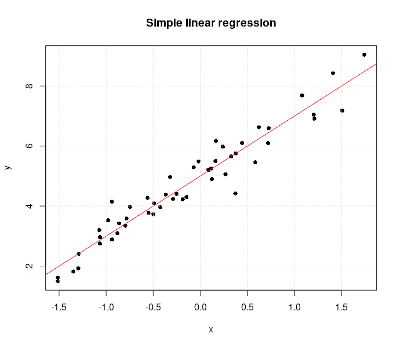

**Generalized Linear Models** are based on the following equation:<br>
${Y=X \beta + \epsilon}$ 
<br>
in which $Y$ is the response vector, $X$ is the matrix of predictors, $\beta$ is a set of unknown parameters and $\epsilon$ is a set of unobservable random variables called errors.

\begin{align}
{Y = \begin{bmatrix}
    y_{0}        \\
    y_{1}       \\
    \vdots  \\
    y_{n}   
\end{bmatrix}} \space \space \space \space
{X = \begin{bmatrix}
    x_{11}       & x_{12} & x_{13} & \dots & x_{1p} \\
    x_{21}       & x_{22} & x_{23} & \dots & x_{2p} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{n1}       & x_{n2} & x_{n3} & \dots & x_{np}
\end{bmatrix}} \space \space \space \space
{\beta = \begin{bmatrix}
    \beta_{0}        \\
    \beta_{1}       \\
    \vdots  \\
    \beta_{p}   
\end{bmatrix}} \space \space \space \space
{\epsilon = \begin{bmatrix}
    \epsilon_{0}        \\
    \epsilon_{1}       \\
    \vdots  \\
    \epsilon_{n}   
\end{bmatrix}}
\end{align}

Our goal is to find $\beta$ such that ${|| Y -  X \beta ||^2}$ is minimized. <br>

$X$ has as many rows as the number of training samples and $p+1$ columns where $p$ is the number of predictiors, that in this case, after feature selection is 7 plus one first column that is an all one column that is used for the intercept (${\beta_{0}}$).<br>

Basically, each prediction in  $X \beta$ is made by a linear combination of the features, weighted by $\beta$<br>
${y_i = \sum_{j=0}^p{x_j\beta_j}}$
<br>
that is the prediction for the i-th observation according to the $p$ predictors.

Usually, **linear regression is not suggested for binary classification** because it can output values below 0 or above 1 (nonsense, assuming probabilistic meaning).<br>
In this case I decided to perform it anyway to **compare the results** with another regression technique called **logistic regression** that instead is very suitable for binary classification.

In [ ]:
# holdout

threshold=0.5

# oversampled 
lr = LinearRegression(fit_intercept=True)
lr.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_rs = pred.copy()
pred[pred>=0.5]=1
pred[pred<0.5]=0
rs_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
rs_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
rs_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
rs_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))
    
# SMOTE 
lr = LinearRegression(fit_intercept=True)
lr.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_sm = pred.copy()
pred[pred>=0.5]=1
pred[pred<0.5]=0
sm_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
sm_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
sm_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
sm_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))
    
# not oversampled
lr = LinearRegression(fit_intercept=True)
lr.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_no_rs = pred.copy()
pred[pred>=0.5]=1
pred[pred<0.5]=0
no_rs_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))

In [ ]:
# oversampled 
lr = LinearRegression(fit_intercept=True)
rs_acc, rs_rec, rs_pre, rs_f1 = kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5, resampling="oversampling")
    
# SMOTE 
lr = LinearRegression(fit_intercept=True)
sm_acc, sm_rec, sm_pre, sm_f1 = kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5, resampling="SMOTE", cached=True)
    
# not oversampled
lr = LinearRegression(fit_intercept=True)
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5)

In [ ]:
# https://python-graph-gallery.com/11-grouped-barplot/

fig = plt.figure(figsize=(6, 4))
barWidth = 0.25
space=0.0
 
bars1 = [no_rs_f1, no_rs_rec, no_rs_pre, no_rs_acc]
bars2 = [rs_f1, rs_rec, rs_pre, rs_acc]
bars3 = [sm_f1, sm_rec, sm_pre, sm_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]

plt.barh(r3, bars1, label="Original",height=barWidth, edgecolor='white')
plt.barh(r2, bars2, label="Oversampling", height=barWidth, edgecolor='white')
plt.barh(r1, bars3, label="SMOTE", height=barWidth, edgecolor='white')

plt.title("Mean values on 5-Fold CV")
plt.yticks([r + barWidth for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy"])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend();

In [ ]:
# area under the curve evaluation
def roc_area(tpr, fpr):
    area = 0
    for i in range(len(tpr)-1):
        base = fpr[i+1]-fpr[i]
        h = tpr[i]
        area += base*h
        
    return round(area, 3)

In [ ]:
fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_sm)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='#990303')

plt.subplot(1, 3, 2)
plt.plot(fpr_rs, tpr_rs, label=f"Oversampling (area={roc_area(tpr_rs, fpr_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(fpr_rs, 0, tpr_rs, alpha=0.05, color='#990303')

plt.subplot(1, 3, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='#990303');

plt.tight_layout()

<a id='Logistic_regression'></a>
## Logistic Regression <a style="text-decoration:none" href="#Classification_models">⤴</a>

Logistic regression is a generalized linear model in which the link function is not the identity (as in the case of linear regression) but is the **logit**.<br>

\begin{align}
{logit(p) = ln(\frac {p}{1-p})}
\end{align}

The **link function** is a function connecting the expected value of the response and the linear combination of predictors.<br>
Practically:<br>

\begin{align}
{logit(p(X)) = X\cdot\beta}
\end{align}

\begin{align}
{p(X) = logit^{-1}(X\cdot\beta)}
\end{align}

\begin{align}
{p(X) = S(X\cdot\beta)}
\end{align}

where $p$ is the expected value of the prediction that in this case (binary) can be modeled as a bernoulli.<br>

The logit "stretches" the interval (0, 1) into the whole real line.
The inverse of the logit is called **sigmoid**:

\begin{align}
{\displaystyle S(x)={\frac {1}{1+e^{-x}}}={\frac {e^{x}}{e^{x}+1}}.}
\end{align}
so:
\begin{align}
{p(X) = \frac{e^{X \beta}}{1+e^{X \beta}}}
\end{align}

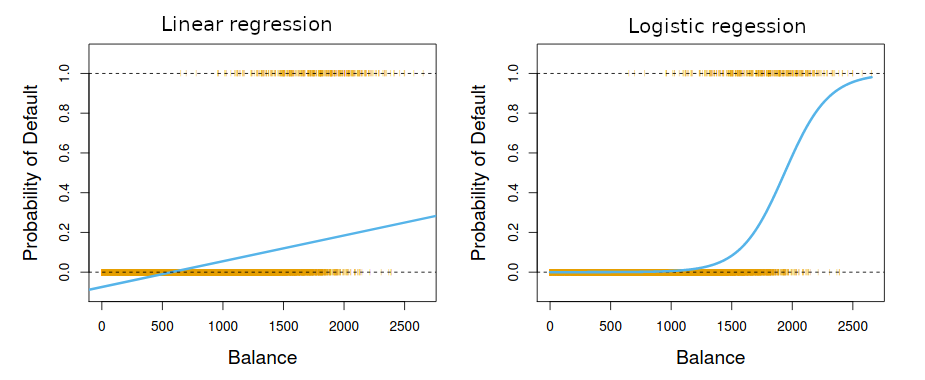

In this way every prediction is bounded between 0 and 1, assuming a probabilistic meaning.<br>
For this reason, logistic regression is very suitable for binary classification.

Here we can see the results on our dataset:

In [ ]:
c = 1
penalty = "l2"
solver = "liblinear"
multi_class = "auto"

# oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_rs = lr.predict_proba(ho_val_df[all_features])[:, 1]

rs_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
rs_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
rs_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
rs_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))
    
# SMOTE 
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_sm = lr.predict_proba(ho_val_df[all_features])[:, 1]

sm_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
sm_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
sm_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
sm_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))
    
# not oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_no_rs = lr.predict_proba(ho_val_df[all_features])[:, 1]

no_rs_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))

# class-weight
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight="balanced",
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_w = lr.predict_proba(ho_val_df[all_features])[:, 1]

w_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
w_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
w_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
w_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))

In [ ]:
# oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

rs_acc, rs_rec, rs_pre, rs_f1 = kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'],
                                                  threshold=0.5, resampling="oversampling")
    
# SMOTE 
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

sm_acc, sm_rec, sm_pre, sm_f1= kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'],
                                                 threshold=0.5, resampling="SMOTE", cached=True)
    
# not oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5)

# class-weight
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight="balanced",
                   random_state=42, solver=solver, multi_class=multi_class)

w_acc, w_rec, w_pre, w_f1= kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5)

In [ ]:
'''
print(f"no_rs:{no_rs_acc},{no_rs_f1}")
print(f"rs:{rs_acc},{rs_f1}")
print(f"sm:{sm_acc},{sm_f1}")
print(f"w:{w_acc},{w_f1}")
''';

In [ ]:
# https://python-graph-gallery.com/11-grouped-barplot/

fig = plt.figure(figsize=(6, 4))
barWidth = 0.2
space=0.01
 
bars1 = [no_rs_f1, no_rs_rec, no_rs_pre, no_rs_acc]
bars2 = [rs_f1, rs_rec, rs_pre, rs_acc]
bars3 = [sm_f1, sm_rec, sm_pre, sm_acc]
bars4 = [w_f1, w_rec, w_pre, w_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]
r4 = [x + barWidth + space for x in r3]

plt.barh(r4, bars1, label="Original",height=barWidth, edgecolor='white', )
plt.barh(r3, bars2, label="Oversampling", height=barWidth, edgecolor='white',)
plt.barh(r2, bars3, label="SMOTE", height=barWidth, edgecolor='white', )
plt.barh(r1, bars4, label="class-weight", height=barWidth, edgecolor='white', )

plt.title("Mean values on 5-Fold CV")
plt.yticks([r + barWidth*1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy", ])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend();

In [ ]:
fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_sm)
fpr_w, tpr_w, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_w)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='#990303')

plt.subplot(2, 2, 2)
plt.plot(fpr_rs, tpr_rs, label=f"Oversampling (area={roc_area(tpr_rs, fpr_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(fpr_rs, 0, tpr_rs, alpha=0.05, color='#990303')

plt.subplot(2, 2, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='#990303')

plt.subplot(2, 2, 4)
plt.plot(fpr_w, tpr_w, label=f"Class-weight (area={roc_area(tpr_w, fpr_w)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [class-weight balanced]")
plt.fill_between(fpr_w, 0, tpr_w, alpha=0.05, color='#990303');

plt.tight_layout()

<a id='Support_vector_machine'></a>
## Support Vector Machine <a style="text-decoration:none" href="#Classification_models">⤴</a>

Support vector machine is a powerful model used for both classification and regression.<br>
It consists in trying to fit an hyperplane that best divides the dataset into the two classes by maximizing the margin (the distance between the hyperplane and the closest points).

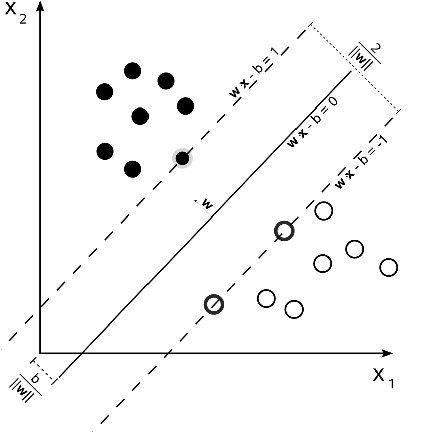
#### Hard margin
The simplest implementation is the hard margin SVM in which data needs to be linearly separable to allow the algorithm to converge.<br>
Considering the hyperplane described by the vector **w** such that:<br>

\begin{align}
{L=\{v:\langle w,v\rangle+ b= 0\}}\space , \space ‖w‖=1
\end{align}

the distance of a point fom the hyperplane L can be evaluated in that way:<br>

\begin{align}
{d(x,L) =| \langle w,x \rangle+ b |}
\end{align}

while the distance between two points of two different classes on the margin is:

\begin{align}
\frac{<x_{+} - x_{-}, W>}{\left \| W \right \|} = \frac{(<x_{+}, W> + \space b) - (<x_{-}, W> + \space b)}{\left \| W \right \|} = \frac{2}{\left \| W \right \|}
\end{align}

So we need to find w and b such that that distance is **maximized** (considering the whole training set) and at the same time all the points are **classified correctly**.<br>
Equivalently:<br>

\begin{align}
{min_{w,b} \frac{1}{2}‖w‖^2 \space\space s.t. \space\space \forall i,\space\space y_i \big(\langle w,x_i\rangle+b \big)>1}
\end{align}

where $y_i$ is the true label and the prediction is the evaluated distance of the sample from the hyperplane.
Basically if the label and the prediction have the same sign it means that the prediction is on the correct side of the margin.<br>
When the algorithm has converged, then the model can be described using only the points on the margin (called **support vectors**). This means that SVM can scale well.<br>
Being able to respect this constraint means having a linearly separable problem.<br>
The main drawback is that, in the real world, the vast majority of the problems are not linearly separable, and an algorithm like this one would not converge.<br>
For this reason we can add a term on the constraints to relax them.

#### Soft margin
In this implementation, a 
<span style="color:red">relaxation</span>
is added to the constraint.<br>

\begin{align}
{
min_{w,b} \Big(\frac{1}{2} ‖W‖^2 + {\color{red} {C  \sum_{i=1}^{m} {\xi_i}}}\Big)
\space \space
s.t.
\space \space
\forall i,\space\space y_i \big(\langle w,x_i\rangle+b \big)≥ 1 \color{red}{−\xi_i\space\space and \space\space \xi_i≥0}
} 
\end{align}

$\xi_i$ is called **slack variable**, it is the distance of $x_i$ from the corresponding class's margin if $x_i$ is on the wrong side of the margin and 0 otherwise.<br>
Smaller values of C allows more errors in exchange of a bigger margin, while higher values can be used where it's needed to be less permissive regarding misclassificatons, with an higher risk of overfitting.

In some cases, problems are not well separable on the original feature space but they are separable on another space.<br>
Therefore it's possible to map our features in another higher dimensional space in which hopefully it will be easier to learn.<br>
One simple example is the polynomial mapping:<br>

A degree k polynomial is 
$p(x)=\sum_{j=0}^{k}w_jx^j\space$

that can also be seen as:
$\space \langle w,\psi(x)\rangle \space \space where \space \space \psi(x) = (1,x,x^2,...,x^k)$<br>

$\psi(x)$ is the polynomial mapping function

The problems arise in the case of multiple predictors.<br>
In fact in a polynomial mapping on a $\rm I\!R^2$ space:

$ \psi(\textbf{x}) = (x_1^2, x_2^2, \sqrt2x_1x_2)$ <br>
(considering only the quadratic features)

This means that, in the cases in which there are a lot of features, mapping every time from the original to the new space could be costly (second order features in 1000 dimensions are around $5\cdot10^5$ numbers)<br>
The solution is using kernel functions.<br>

#### Kernel trick
To solve the svm optimization problem, computing inner products it's needed.<br>
In fact, according to **representer theorem**, $w$ can be written as:

${w = \sum_{i} \alpha_i\psi(x_i)}\space$

so it follows that: <br>

$\space ‖w‖^2 = \langle \sum_j{\alpha_j\psi(x_j)}, \sum_j{\alpha_j\psi(x_j)}\rangle = \sum_{i,j=1}^{m}\alpha_i\alpha_j\langle\psi(x_i),\psi(x_j)\rangle $

and the problem now consists in maximizing the margin over $\alpha$.<br>
Once $\alpha$ vector is obtained, **support vectors** correspond to samples that have an alpha value that is greater than zero (so to describe the model, only those samples are needed).

Considering the mapping, this operation could be unfeasible.<br>
A **kernel function** is a function that implements the inner product in the new feature space (given $\psi$):<br>

${ K(\textbf{x},\textbf{x}^\prime) =\langle\psi(\textbf{x}),\psi(\textbf{x}^\prime)\rangle}$

In this way we don't have to explicitly apply ${\psi}$ on our data and then compute the inner product.<br>

A symmetric function $K: X\times X \rightarrow \rm I\!R$ can be a kernel function if and only if it respects the **Mercer theorem** that says that the Gram matrix, that is the matrix such that:
${G_{i,j} = K (\textbf{x}_i, \textbf{x}_j)}$ needs to be **positive semidefinite**.

A matrix is semidefinite if and only if:

${\textbf{x}^T G \textbf{x} > 0\space \space\forall \textbf{x}\in R^n \backslash 0}$<br>
and the aigenvalues are **non-negative**.

<br><br>
The most used kernels are:
* the **polynomial kernel** (degree k)<br>
${(\langle \textbf{x}, \textbf{x}^\prime \rangle + 1)^k }$


* the **radial basis function** (gaussian kernel)<br>
${e^{-\gamma ‖\textbf{x} - \textbf{x}^\prime‖^2}}$

Linear kernel means that no mapping is done and the kernel is simply ${\langle \textbf{x}, \textbf{x}^\prime\rangle}$

To better see how soft margin svm works with different kernels, we can see the classification according to `serum_creatinine` and `ejection_fraction`.<br>
Then the same algorithm will be tested on all the 7 features of the original, oversampled and SMOTE dataset.

In [ ]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [ ]:
%matplotlib notebook
plt.ioff()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3);
%matplotlib inline 
plt.ion()

C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
h = 0.03
x_min, x_max = hf_norm["ejection_fraction"].min() - .5, hf_norm["ejection_fraction"].max() + .5
y_min, y_max = hf_norm["serum_creatinine"].min() - .5, hf_norm["serum_creatinine"].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

fig.set_size_inches(11, 4);
def animate_func(i):  
    # linear
    svm = SVC(C=C[i], kernel='linear', random_state=42, class_weight='balanced', probability=True)
    svm.fit(hf_norm[["ejection_fraction", "serum_creatinine"]], hf_norm['DEATH_EVENT'])

    Z = svm.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    
    ax1.clear()
    ax1.contourf(xx, yy, Z, alpha=0.7, cmap=cm_rev, antialiased=True)
    ax1.scatter(hf_norm[hf_norm["DEATH_EVENT"]==0]["ejection_fraction"],
                hf_norm[hf_norm["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax1.scatter(hf_norm[hf_norm["DEATH_EVENT"]==1]["ejection_fraction"],
                hf_norm[hf_norm["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax1.set_xlabel("ejection_fraction")
    ax1.set_ylabel("serum_creatinine")
    ax1.legend();
    ax1.set_title(f"Linear (C={C[i]})")
    
    # poly
    svm = SVC(C=C[i], kernel='poly', random_state=42, gamma='auto', degree=3, class_weight='balanced', probability=True)
    svm.fit(hf_norm[["ejection_fraction", "serum_creatinine"]], hf_norm['DEATH_EVENT'])

    Z = svm.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    ax2.clear()
    ax2.contourf(xx, yy, Z, alpha=0.7, cmap=cm_rev, antialiased=True)
    ax2.scatter(hf_norm[hf_norm["DEATH_EVENT"]==0]["ejection_fraction"],
                hf_norm[hf_norm["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax2.scatter(hf_norm[hf_norm["DEATH_EVENT"]==1]["ejection_fraction"],
                hf_norm[hf_norm["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax2.set_xlabel("ejection_fraction")
    ax2.set_ylabel("serum_creatinine")
    ax2.legend();
    ax2.set_title(f"Polynomial (C={C[i]})")

    # rbf
    svm = SVC(C=C[i], kernel='rbf', random_state=42, gamma='auto', class_weight='balanced', probability=True)
    svm.fit(hf_norm[["ejection_fraction", "serum_creatinine"]], hf_norm['DEATH_EVENT'])

    Z = svm.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    ax3.clear()
    ax3.contourf(xx, yy, Z, alpha=0.7, cmap=cm_rev, antialiased=True)
    
    ax3.scatter(hf_norm[hf_norm["DEATH_EVENT"]==0]["ejection_fraction"],
                hf_norm[hf_norm["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax3.scatter(hf_norm[hf_norm["DEATH_EVENT"]==1]["ejection_fraction"],
                hf_norm[hf_norm["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax3.set_xlabel("ejection_fraction")
    ax3.set_ylabel("serum_creatinine")
    ax3.legend();
    ax3.set_title(f"Radial Basis Function (C={C[i]})")
    
    fig.tight_layout()
    return [fig]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(C),
                               interval = 500, # in ms
                               );
HTML(anim.to_jshtml())

Now let's apply it on our actual classification task.

<a id='Linear_kernel'></a>
### Linear kernel

In [ ]:
C = 1

# original
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
svm.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
lin_raw_pred_no_rs = svm.predict_proba(ho_val_df[all_features])[:, 1]

lin_no_rs_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
lin_no_rs_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
lin_no_rs_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
lin_no_rs_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

# oversampled
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
svm.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
lin_raw_pred_rs = svm.predict_proba(ho_val_df[all_features])[:, 1]

lin_rs_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
lin_rs_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
lin_rs_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
lin_rs_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

# SMOTE
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
svm.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
lin_raw_pred_sm = svm.predict_proba(ho_val_df[all_features])[:, 1]

lin_sm_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
lin_sm_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
lin_sm_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
lin_sm_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

# class-weight balanced
svm = SVC(kernel="linear", random_state=42, probability=True, class_weight="balanced", C = C)
svm.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
lin_raw_pred_w = svm.predict_proba(ho_val_df[all_features])[:, 1]

lin_w_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
lin_w_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
lin_w_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
lin_w_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

In [ ]:
'''
print(f"no_rs:{lin_no_rs_acc},{lin_no_rs_f1}")
print(f"rs:{lin_rs_acc},{lin_rs_f1}")
print(f"sm:{lin_sm_acc},{lin_sm_f1}")
print(f"w:{lin_w_acc},{lin_w_f1}")
''';

In [ ]:
# original
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
lin_no_rs_acc, lin_no_rs_pre, lin_no_rs_rec, lin_no_rs_f1 = kfold.fit_predict(svm, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5, resampling="oversampling")

# oversampled
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
lin_rs_acc, lin_rs_pre, lin_rs_rec, lin_rs_f1 = kfold.fit_predict(svm, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5, resampling="SMOTE", cached=True)

# SMOTE
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
lin_sm_acc, lin_sm_pre, lin_sm_rec, lin_sm_f1 = kfold.fit_predict(svm, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5)

# class-weight balanced
svm = SVC(kernel="linear", random_state=42, probability=True, class_weight="balanced", C = C)
lin_w_acc, lin_w_pre, lin_w_rec, lin_w_f1 = kfold.fit_predict(svm, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5)

In [ ]:
'''
print(f"no_rs:{lin_no_rs_acc},{lin_no_rs_f1}")
print(f"rs:{lin_rs_acc},{lin_rs_f1}")
print(f"sm:{lin_sm_acc},{lin_sm_f1}")
print(f"w:{lin_w_acc},{lin_w_f1}")
''';

In [ ]:
# https://python-graph-gallery.com/11-grouped-barplot/

fig = plt.figure(figsize=(6, 4))
barWidth = 0.2
space=0.01
 
bars1 = [lin_no_rs_f1, lin_no_rs_rec, lin_no_rs_pre, lin_no_rs_acc]
bars2 = [lin_rs_f1, lin_rs_rec, lin_rs_pre, lin_rs_acc]
bars3 = [lin_sm_f1, lin_sm_rec, lin_sm_pre, lin_sm_acc]
bars4 = [lin_w_f1, lin_w_rec, lin_w_pre, lin_w_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]
r4 = [x + barWidth + space for x in r3]

plt.barh(r4, bars1, label="Original",height=barWidth, edgecolor='white')
plt.barh(r3, bars2, label="Oversampling", height=barWidth, edgecolor='white')
plt.barh(r2, bars3, label="SMOTE", height=barWidth, edgecolor='white')
plt.barh(r1, bars4, label="class-weight", height=barWidth, edgecolor='white')

plt.title("Mean values on 5-Fold CV")
plt.yticks([r + barWidth*1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy", ])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend();

In [ ]:
from sklearn.metrics import roc_curve

fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], lin_raw_pred_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], lin_raw_pred_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], lin_raw_pred_sm)
fpr_w, tpr_w, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], lin_raw_pred_w)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='#990303')

plt.subplot(2, 2, 2)
plt.plot(fpr_rs, tpr_rs, label=f"Oversampling (area={roc_area(tpr_rs, fpr_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(fpr_rs, 0, tpr_rs, alpha=0.05, color='#990303')

plt.subplot(2, 2, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='#990303')

plt.subplot(2, 2, 4)
plt.plot(fpr_sm, tpr_sm, label=f"class-weight (area={roc_area(tpr_w, fpr_w)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [class-weight='balanced']")
plt.fill_between(fpr_w, 0, tpr_w, alpha=0.05, color='#990303')

plt.tight_layout()

<a id='Polynomial_and_RBF_kernels'></a>
### Polynomial and RBF kernels
<a id='Gridsearch on C and gamma'></a>
#### Gridsearch on C and gamma

Gamma is a kernel coefficient used in both polynomial and RBF kernels.<br>
For RBF kernels, gamma is the coefficient multiplied to the squared norm of $x-x^\prime$ while for polynomial kernel, in the `libsvm` implementation (the one used by sklearn library), the kernel function is ${(\gamma \langle \textbf{x}, \textbf{x}^\prime \rangle + 1)^k }$

Gridsearch model selection is done with KFold crossvalidation.

In [ ]:
def _make_combinations(lenghts, n, comb, combs):
    if len(lenghts)==n:
        combs.append(comb.copy())
    else:
        for i in range(lenghts[n]):
            combs = _make_combinations(lenghts, n+1, comb+[i], combs)
    return combs

def make_combinations(lenghts):
    combs = []
    combs = _make_combinations(lenghts, 0, [], combs)
    return combs

In [ ]:
def gridsearch(model, train_set, train_lab, params, starting_conf, resampling = None):
    
    results = []
    lenghts = [len(params[l]) for l in params.keys()]
    combs = make_combinations(lenghts)
    n_params = len(params.keys())

    for comb in combs:
        conf = starting_conf.copy()
        for i, param in enumerate(params.keys()):
            conf[param]=params[param][comb[i]]
        
        m = model(**conf)
        
        acc, pre, rec, f1 = kfold.fit_predict(model=m, X = train_set, y = train_lab, resampling=resampling, cached=True)
        results.append([acc, f1, conf])
    return np.asarray(results)  

In [ ]:
variable_params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "gamma": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

In [ ]:
# Original dataset
plt.figure(figsize=(9, 8))

# poly 3 degree
plt.subplot(2, 2, 1)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, 'max_iter':100000}
results = gridsearch(SVC, ho_train_df, ho_train_df['DEATH_EVENT'], variable_params, starting_params)

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="viridis")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [Original] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

plt.subplot(2, 2, 2)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="inferno")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [Original] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

# rbf
plt.subplot(2, 2, 3)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"rbf", 'max_iter':100000}
results = gridsearch(SVC, ho_train_df, ho_train_df['DEATH_EVENT'], variable_params, starting_params)

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="viridis")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [Original] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

plt.subplot(2, 2, 4)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="inferno")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [Original] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

In [ ]:
# random oversampling dataset
plt.figure(figsize=(9, 8))

# poly 3 degree
plt.subplot(2, 2, 1)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, 'max_iter':100000}
results = gridsearch(SVC, ho_train_df, ho_train_df['DEATH_EVENT'], variable_params, 
                     starting_params, resampling="oversampling")

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="viridis")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [Oversampling] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

plt.subplot(2, 2, 2)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="inferno")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [Oversampling] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

# rbf
plt.subplot(2, 2, 3)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"rbf", 'max_iter':100000}
results = gridsearch(SVC, ho_train_df, ho_train_df['DEATH_EVENT'], variable_params,
                     starting_params, resampling="oversampling")

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="viridis")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [Oversampling] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

plt.subplot(2, 2, 4)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="inferno")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [Oversampling] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

In [ ]:
# SMOTE dataset
plt.figure(figsize=(9, 8))

# poly 3 degree
plt.subplot(2, 2, 1)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, 'max_iter':100000}

results = gridsearch(SVC, ho_train_df, ho_train_df['DEATH_EVENT'], variable_params, 
                     starting_params, resampling="SMOTE")

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="viridis")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [SMOTE] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

plt.subplot(2, 2, 2)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="inferno")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [SMOTE] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

# rbf
plt.subplot(2, 2, 3)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"rbf", 'max_iter':100000}
results = gridsearch(SVC, ho_train_df, ho_train_df['DEATH_EVENT'], variable_params,
                     starting_params, resampling="SMOTE")

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="viridis")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [SMOTE] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

plt.subplot(2, 2, 4)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="inferno")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [SMOTE] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

In [ ]:
# class weight
plt.figure(figsize=(9, 8))

# poly 3 degree
plt.subplot(2, 2, 1)

starting_params = {"class_weight":"balanced", "random_state": 42, "kernel":"poly" , "degree": 3, 'max_iter':100000}
results = gridsearch(SVC, ho_train_df, ho_train_df['DEATH_EVENT'], variable_params, 
                     starting_params)

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="viridis")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3)\n [class-weight balanced] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

plt.subplot(2, 2, 2)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="inferno")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3)\n [class-weight balanced] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

# rbf
plt.subplot(2, 2, 3)

starting_params = {"class_weight":"balanced", "random_state": 42, "kernel":"rbf", 'max_iter':100000}
results = gridsearch(SVC, ho_train_df, ho_train_df['DEATH_EVENT'], variable_params,
                     starting_params)

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="viridis")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [class-weight balanced] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

plt.subplot(2, 2, 4)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap="inferno")
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [class-weight balanced] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

In [ ]:
best_poly_no_rs = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, "C":0.1, "gamma":1, "probability":True}
best_rbf_no_rs = {"class_weight":None, "random_state": 42, "kernel":"rbf" , "C":10, "gamma":0.1, "probability":True}

best_poly_rs = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, "C":0.1, "gamma":1, "probability":True}
best_rbf_rs = {"class_weight":None, "random_state": 42, "kernel":"rbf" , "C":0.1, "gamma":1, "probability":True}

best_poly_sm = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, "C":100, "gamma":0.1, "probability":True}
best_rbf_sm = {"class_weight":None, "random_state": 42, "kernel":"rbf" , "C":1, "gamma":0.1, "probability":True}

best_poly_w = {"class_weight":"balanced", "random_state": 42, "kernel":"poly" , "degree": 3, "C":10, "gamma":0.1, "probability":True}
best_rbf_w = {"class_weight":"balanced", "random_state": 42, "kernel":"rbf" , "C":1, "gamma":0.1, "probability":True}

Best models are re-trained on the whole training set and then evaluated on the validation set.

<a id='Polynomial_kernel'></a>
### Polynomial kernel - best models

In [ ]:
# original
svm = SVC(**best_poly_no_rs)
svm.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
poly_raw_pred_no_rs = svm.predict_proba(ho_val_df[all_features])[:, 1]

poly_no_rs_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
poly_no_rs_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
poly_no_rs_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
poly_no_rs_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

# oversampling
svm = SVC(**best_poly_rs)
svm.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
poly_raw_pred_rs = svm.predict_proba(ho_val_df[all_features])[:, 1]

poly_rs_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
poly_rs_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
poly_rs_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
poly_rs_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

# SMOTE
svm = SVC(**best_poly_sm)
svm.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
poly_raw_pred_sm = svm.predict_proba(ho_val_df[all_features])[:, 1]

poly_sm_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
poly_sm_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
poly_sm_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
poly_sm_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

# class-weight balanced
svm = SVC(**best_poly_w)
svm.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
poly_raw_pred_w = svm.predict_proba(ho_val_df[all_features])[:, 1]

poly_w_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
poly_w_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
poly_w_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
poly_w_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

In [ ]:
'''
print(f"no_rs:{poly_no_rs_acc},{poly_no_rs_f1}")
print(f"rs:{poly_rs_acc},{poly_rs_f1}")
print(f"sm:{poly_sm_acc},{poly_sm_f1}")
print(f"w:{poly_w_acc},{poly_w_f1}")
''';

In [ ]:
# https://python-graph-gallery.com/11-grouped-barplot/

fig = plt.figure(figsize=(6, 4))
barWidth = 0.2
space=0.01
 
bars1 = [poly_no_rs_f1, poly_no_rs_rec, poly_no_rs_pre, poly_no_rs_acc]
bars2 = [poly_rs_f1, poly_rs_rec, poly_rs_pre, poly_rs_acc]
bars3 = [poly_sm_f1, poly_sm_rec, poly_sm_pre, poly_sm_acc]
bars4 = [poly_w_f1, poly_w_rec, poly_w_pre, poly_w_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]
r4 = [x + barWidth + space for x in r3]

plt.barh(r4, bars1, label="Original [C:0.1, gamma:1]",height=barWidth, edgecolor='white', )
plt.barh(r3, bars2, label="Oversampling [C:0.1, gamma:1]", height=barWidth, edgecolor='white',)
plt.barh(r2, bars3, label="SMOTE [C:100, gamma:0.1]", height=barWidth, edgecolor='white', )
plt.barh(r1, bars4, label="class-weight [C:10, gamma:0.1]", height=barWidth, edgecolor='white', )

plt.yticks([r + barWidth*1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy", ])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
from sklearn.metrics import roc_curve

fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], poly_raw_pred_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], poly_raw_pred_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], poly_raw_pred_sm)
fpr_w, tpr_w, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], poly_raw_pred_w)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='#990303')

plt.subplot(2, 2, 2)
plt.plot(fpr_rs, tpr_rs, label=f"Oversampling (area={roc_area(tpr_rs, fpr_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(fpr_rs, 0, tpr_rs, alpha=0.05, color='#990303')

plt.subplot(2, 2, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='#990303')

plt.subplot(2, 2, 4)
plt.plot(fpr_w, tpr_w, label=f"class-weight (area={roc_area(tpr_w, fpr_w)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [class-weight balanced]")
plt.fill_between(fpr_w, 0, tpr_w, alpha=0.05, color='#990303')

plt.tight_layout()

<a id='RBF_kernel'></a>
### RBF kernel - best models

In [ ]:
# original
svm = SVC(**best_rbf_no_rs)
svm.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
rbf_raw_pred_no_rs = svm.predict_proba(ho_val_df[all_features])[:, 1]

rbf_no_rs_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
rbf_no_rs_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
rbf_no_rs_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
rbf_no_rs_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

# oversampling
svm = SVC(**best_rbf_rs)
svm.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
rbf_raw_pred_rs = svm.predict_proba(ho_val_df[all_features])[:, 1]

rbf_rs_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
rbf_rs_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
rbf_rs_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
rbf_rs_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

# SMOTE
svm = SVC(**best_rbf_sm)
svm.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
rbf_raw_pred_sm = svm.predict_proba(ho_val_df[all_features])[:, 1]

rbf_sm_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
rbf_sm_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
rbf_sm_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
rbf_sm_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

# class-weight balanced
svm = SVC(**best_rbf_w)
svm.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])

pred = svm.predict(ho_val_df[all_features])
rbf_raw_pred_w = svm.predict_proba(ho_val_df[all_features])[:, 1]

rbf_w_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
rbf_w_pre = recall_score(ho_val_df["DEATH_EVENT"], pred)
rbf_w_rec = precision_score(ho_val_df["DEATH_EVENT"], pred)
rbf_w_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

In [ ]:
'''
print(f"no_rs:{rbf_no_rs_acc},{rbf_no_rs_f1}")
print(f"rs:{rbf_rs_acc},{rbf_rs_f1}")
print(f"sm:{rbf_sm_acc},{rbf_sm_f1}")
print(f"w:{rbf_w_acc},{rbf_w_f1}")
''';

In [ ]:
# https://python-graph-gallery.com/11-grouped-barplot/

fig = plt.figure(figsize=(6, 4))
barWidth = 0.2
space=0.01
 
bars1 = [rbf_no_rs_f1, rbf_no_rs_rec, rbf_no_rs_pre, rbf_no_rs_acc]
bars2 = [rbf_rs_f1, rbf_rs_rec, rbf_rs_pre, rbf_rs_acc]
bars3 = [rbf_sm_f1, rbf_sm_rec, rbf_sm_pre, rbf_sm_acc]
bars4 = [rbf_w_f1, rbf_w_rec, rbf_w_pre, rbf_w_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]
r4 = [x + barWidth + space for x in r3]

plt.barh(r4, bars1, label="Original [C:10, gamma:0.1]",height=barWidth, edgecolor='white', )
plt.barh(r3, bars2, label="Oversampling [C:0.1, gamma:1]", height=barWidth, edgecolor='white',)
plt.barh(r2, bars3, label="SMOTE [C:1, gamma:0.1]", height=barWidth, edgecolor='white', )
plt.barh(r1, bars4, label="class-weight [C:1, gamma:0.1]", height=barWidth, edgecolor='white', )

plt.yticks([r + barWidth*1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy"])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], rbf_raw_pred_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], rbf_raw_pred_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], rbf_raw_pred_sm)
fpr_w, tpr_w, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], rbf_raw_pred_w)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='#990303')

plt.subplot(2, 2, 2)
plt.plot(fpr_rs, tpr_rs, label=f"Oversampling (area={roc_area(tpr_rs, fpr_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(fpr_rs, 0, tpr_rs, alpha=0.05, color='#990303')

plt.subplot(2, 2, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='#990303')

plt.subplot(2, 2, 4)
plt.plot(fpr_w, tpr_w, label=f"class-weight (area={roc_area(tpr_w, fpr_w)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [class-weight balanced]")
plt.fill_between(fpr_w, 0, tpr_w, alpha=0.05, color='#990303')

plt.tight_layout()

<a id='K_nearest_neighbors'></a>
## K Nearest Neighbors <a style="text-decoration:none" href="#Classification_models">⤴</a>
KNN model tries to classify new points according to the class of the nearest neighbors.<br>
Nearest neighbors are evaluated according to a **distance metric** function and for each new point, only a fixed number of neighbors are taken into account.<br>
This model is quite simple but it doesn't scale well.<br>
In fact, to predict a new point is necessary to store the entire dataset, so when the number of features or the number of records is very high, the computation could be heavy.<br>
Considering the way KNN learns, it is possible to re-train an already trained model on new data.<br>
<br>
The parameters taken into account are, of course, the number of neighbors but also the distance metric that is the **minkowski distance**:<br>

${\Big(\sum_{i=1}^{n}{|x_i-y_i|^p}\Big)^{1/p}}$

in which the parameter $p$ is changed.<br>
Then is also possible to **weight** the neighbors according to their distance from the new point.(`weights=distance`)<br>

In [ ]:
n_neigh = [1, 5, 10, 20, 50]
metric = "minkowski"
p = [2, 3, 4, 5]
h = 0.03

x_min, x_max = hf_norm["ejection_fraction"].min() - .5, hf_norm["ejection_fraction"].max() + .5
y_min, y_max = hf_norm["serum_creatinine"].min() - .5, hf_norm["serum_creatinine"].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [ ]:
print("Evaluting different number of nearest neighbors")
%matplotlib notebook
plt.ioff()
fig, (ax1, ax2) = plt.subplots(1, 2);
%matplotlib inline 
plt.ion()

fig.set_size_inches(8, 4);
def animate_func(i):
    knn = KNeighborsClassifier(n_neigh[i], weights="uniform", metric=metric, p=2)
    knn.fit(hf_norm[["ejection_fraction", "serum_creatinine"]], hf_norm['DEATH_EVENT'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax1.clear()
    ax1.contourf(xx, yy, Z, alpha=0.5, cmap=cm_rev)

    ax1.scatter(hf_norm[hf_norm["DEATH_EVENT"]==0]["ejection_fraction"],
                    hf_norm[hf_norm["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax1.scatter(hf_norm[hf_norm["DEATH_EVENT"]==1]["ejection_fraction"],
                    hf_norm[hf_norm["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax1.set_xlabel("ejection_fraction")
    ax1.set_ylabel("serum_creatinine")
    ax1.legend();
    ax1.set_title(f"KNN (weights=uniform) n_neigh={n_neigh[i]}")
    
    # distance
    knn = KNeighborsClassifier(n_neigh[i], weights="distance", metric=metric, p=2)
    knn.fit(hf_norm[["ejection_fraction", "serum_creatinine"]], hf_norm['DEATH_EVENT'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax2.clear()
    ax2.contourf(xx, yy, Z, alpha=0.5, cmap=cm_rev)

    ax2.scatter(hf_norm[hf_norm["DEATH_EVENT"]==0]["ejection_fraction"],
                    hf_norm[hf_norm["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax2.scatter(hf_norm[hf_norm["DEATH_EVENT"]==1]["ejection_fraction"],
                    hf_norm[hf_norm["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax2.set_xlabel("ejection_fraction")
    ax2.set_ylabel("serum_creatinine")
    ax2.legend();
    ax2.set_title(f"KNN (weights=distance) n_neigh={n_neigh[i]}")
    
    fig.tight_layout()
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(n_neigh),
                               interval = 500, # in ms
                               );
HTML(anim.to_jshtml())

In [ ]:
print("Evaluating different values of p for minkowski distance metric")
%matplotlib notebook
plt.ioff()
fig, (ax1, ax2) = plt.subplots(1, 2);
%matplotlib inline 
plt.ion()

fig.set_size_inches(8, 4);
def animate_func(i):
    knn = KNeighborsClassifier(10, weights="uniform", metric=metric, p=p[i])
    knn.fit(hf_norm[["ejection_fraction", "serum_creatinine"]], hf_norm['DEATH_EVENT'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax1.clear()
    ax1.contourf(xx, yy, Z, alpha=0.5, cmap=cm_rev)

    ax1.scatter(hf_norm[hf_norm["DEATH_EVENT"]==0]["ejection_fraction"],
                    hf_norm[hf_norm["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax1.scatter(hf_norm[hf_norm["DEATH_EVENT"]==1]["ejection_fraction"],
                    hf_norm[hf_norm["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax1.set_xlabel("ejection_fraction")
    ax1.set_ylabel("serum_creatinine")
    ax1.legend();
    ax1.set_title(f"KNN (weights=uniform) p={p[i]}")
    
    # distance
    knn = KNeighborsClassifier(10, weights="distance", metric=metric, p=p[i])
    knn.fit(hf_norm[["ejection_fraction", "serum_creatinine"]], hf_norm['DEATH_EVENT'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax2.clear()
    ax2.contourf(xx, yy, Z, alpha=0.5, cmap=cm_rev)

    ax2.scatter(hf_norm[hf_norm["DEATH_EVENT"]==0]["ejection_fraction"],
                    hf_norm[hf_norm["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax2.scatter(hf_norm[hf_norm["DEATH_EVENT"]==1]["ejection_fraction"],
                    hf_norm[hf_norm["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax2.set_xlabel("ejection_fraction")
    ax2.set_ylabel("serum_creatinine")
    ax2.legend();
    ax2.set_title(f"KNN (weights=distance) p={p[i]}")
    
    fig.tight_layout()
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(p),
                               interval = 500, # in ms
                               );
HTML(anim.to_jshtml())

Now let's apply it on our training set considering all features 

<a id='weights_original'></a>
### weights = "original"

In [ ]:
n_neigh = range(1, 21, 2)
n = len(n_neigh)

rs_acc, rs_rec, rs_pre, rs_f1 = [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1 = [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = [], [], [], []
rs_raw_pred, sm_raw_pred, no_rs_raw_pred = [], [], []

for i,n in enumerate(n_neigh):
       
    # oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    knn.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    rs_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    rs_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    rs_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    rs_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))

    # SMOTE
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    knn.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    sm_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    sm_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    sm_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    sm_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    sm_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))
        
    #no oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    knn.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    no_rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    no_rs_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))

In [ ]:
#sorted([(a, b) for a, b in zip(sm_acc, sm_f1)], key=lambda a:a[0]+a[1])

In [ ]:
# k fold
rs_acc, rs_rec, rs_pre, rs_f1= [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1= [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= [], [], [], []

for i,n in enumerate(n_neigh):
       
    # oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="oversampling")
    rs_acc.append(acc)
    rs_rec.append(rec)
    rs_pre.append(pre)
    rs_f1.append(f1)

    # SMOTE
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="SMOTE", cached="True")
    sm_acc.append(acc)
    sm_rec.append(rec)
    sm_pre.append(pre)
    sm_f1.append(f1)
        
    #no oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling=None)
    no_rs_acc.append(acc)
    no_rs_rec.append(rec)
    no_rs_pre.append(pre)
    no_rs_f1.append(f1)

In [ ]:
#sorted([(a, b) for a, b in zip(sm_acc, sm_f1)], key=lambda a:a[0]+a[1])

In [ ]:
print("K-Fold cross-validation metrics (5 folds)")
plt.figure(figsize=(10, 10))

# accuracy
plt.subplot(2, 2, 1)    
plt.plot(list(n_neigh), rs_acc, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_acc, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_acc, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation accuracy")
plt.xlabel("n neighbors")
plt.title("Accuracy")

# precision
plt.subplot(2, 2, 2)   
plt.plot(list(n_neigh), rs_pre, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_pre, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_pre, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation precision")
plt.xlabel("n neighbors")
plt.title("Precision")

# recall
plt.subplot(2, 2, 3)    
plt.plot(list(n_neigh), rs_rec, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_rec, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_rec, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation recall")
plt.xlabel("n neighbors")
plt.title("Recall")

# f1 score
plt.subplot(2, 2, 4)    
plt.plot(list(n_neigh), rs_f1, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_f1, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_f1, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation f1 score")
plt.xlabel("n neighbors")
plt.title("F1 score");

<a id='weights_distance'></a>
### weights = "distance"

In [ ]:
n_neigh = range(1, 21, 2)
n = len(n_neigh)

rs_acc, rs_rec, rs_pre, rs_f1= [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1= [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= [], [], [], []
rs_raw_pred, sm_raw_pred, no_rs_raw_pred = [], [], []

for i,n in enumerate(n_neigh):
         
    # oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    knn.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    rs_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    rs_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    rs_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    rs_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))

    # SMOTE
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    knn.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    sm_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    sm_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    sm_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    sm_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    sm_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))
        
    # no oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    knn.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    no_rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    no_rs_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))

In [ ]:
#sorted([(a, b) for a, b in zip(rs_acc, rs_f1)], key=lambda a:a[0]+a[1])

In [ ]:
# k fold

rs_acc, rs_rec, rs_pre, rs_f1= [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1= [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= [], [], [], []

for i,n in enumerate(n_neigh):
         
    # oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="oversampling")
    rs_acc.append(acc)
    rs_rec.append(rec)
    rs_pre.append(pre)
    rs_f1.append(f1)
    
    # SMOTE
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="SMOTE", cached="True")
    sm_acc.append(acc)
    sm_rec.append(rec)
    sm_pre.append(pre)
    sm_f1.append(f1)  
    
    # no oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling=None)
    no_rs_acc.append(acc)
    no_rs_rec.append(rec)
    no_rs_pre.append(pre)
    no_rs_f1.append(f1)

In [ ]:
#sorted([(a, b) for a, b in zip(sm_acc, sm_f1)], key=lambda a:a[0]+a[1])

In [ ]:
print("K-Fold cross-validation metrics (5 folds)")
plt.figure(figsize=(10, 10))

# accuracy
plt.subplot(2, 2, 1)    
plt.plot(list(n_neigh), rs_acc, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_acc, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_acc, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation accuracy")
plt.xlabel("n neighbors")
plt.title("Accuracy")

# precision
plt.subplot(2, 2, 2)   
plt.plot(list(n_neigh), rs_pre, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_pre, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_pre, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation precision")
plt.xlabel("n neighbors")
plt.title("Precision")

# recall
plt.subplot(2, 2, 3)    
plt.plot(list(n_neigh), rs_rec, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_rec, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_rec, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation recall")
plt.xlabel("n neighbors")
plt.title("Recall")

# f1 score
plt.subplot(2, 2, 4)    
plt.plot(list(n_neigh), rs_f1, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_f1, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_f1, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation f1 score")
plt.xlabel("n neighbors")
plt.title("F1 score");

<a id='Naive_bayes'></a>
## Naive Bayes <a style="text-decoration:none" href="#Classification_models">⤴</a>

Naive bayes classifier is a probabilistic model based on the Bayes theorem in which is assumed a strong independence between the features.<br>
The concept is that every feature independently contribute to the final prediction.<br>
Our goal is to find:

\begin{align}
{p(C=k|x_1, \dots, x_n)}
\end{align}

that is the probability of having the class k, given the sample features (considered independent).<br>
**Bayes theorem** tells us that:

\begin{align}
{p(C=k|X=x)=\frac{p(C=k)p(X=x|C=k)}{p(X=x)}}
\end{align}

Basically we have to compute the **feature distributions given the class** $p(X=x|C=k)$, while $p(X=x)$ in this case is called **evidence** and is evaluated in this way: $p(X=x)=\sum_k p(C=k)p(X=x|C=k)$.<br>
$p(C=k)$ is the **prior**.
This represents our prior knowledge on the class distribution. We will see that, changing the prior, the results may be very different.

Once the class probabilities given the sample are computed, one common strategy is to pick the most probable one:

\begin{align}
{\hat{y} = argmax_{k \in {1, \dots, K}} \space p(C=k) \prod_{i=1}^{n}p(X_i=x_i|C=k)}
\end{align}
where  the **evidence** is ignored because is the same for every class.<br>
Since we assume feature independence:

${p(X=x|C=k})=\prod_{i=1}^{n}p(X_i=x_i| C=k)$

To evaluate the probability of a sample given the class, it's important to know the feature distributions.
This is a fundamental prior knowledge on features, picking the wrong distributions can leads to wrong results.

Our dataset is composed by a mix of binary and continouos features.<br>
For the first ones, a **bernoulli distribution** is the easy pick, while for the others an analisys has to be done.<br>
Naive bayes can achieve good results with categorical features so one approach could be **binning** the numerical features into bins and then treat those bins as categories, but the problem is that in that way you risk to lose some important information.<br>
Another approach consists in estimating the continouos distributions.
Altough some of them seems to be gaussians, others are not (`ejection_fractions` seems to be bimodal).<br>
To tackle this problem it's possible to estimate the distributions without trying to fit an already known one, using **kernel density estimation**.

This technique has been proposed in 1995 by **John and Langley** [[3](#references)] under the name of **Flexible Bayes**.

So, to evaluate Naive Bayes classifier, a model based on bernoulli and kde distributions is implemented.<br>
Then, to compare the results, also the classic **Gaussian Naive Bayes** is tested.

Before applying Naive Bayes we need to test that all the features are mutually independent, conditional on the target.<br>
We already tested the linear independence of the features with the correlation matrix, now we can perform the same correlation matrix but considering the samples **given the target label**.

In [ ]:
dead = hf_norm[hf_norm["DEATH_EVENT"]==1][all_features].corr(method='pearson')
alive = hf_norm[hf_norm["DEATH_EVENT"]==0][all_features].corr(method='pearson')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Mutual correlation given DEATH_EVENT=1")
sns.heatmap(dead, vmin=-1, vmax=1, annot=True, xticklabels=False, cmap='viridis', fmt='.2f')

plt.subplot(1, 2, 2)
plt.title("Mutual correlation given DEATH_EVENT=0")
sns.heatmap(alive, vmin=-1, vmax=1, annot=True, xticklabels=False, cmap='viridis', fmt='.2f')

plt.tight_layout()

From the correlation matrices we can see that, apart from some pairs of features (`anaemia`-`CPK`, `sex`-`ejection_fraction`), the vast majority seems to be strongly uncorrelated.

<a id='Kernel_density_estimation'></a>
### Kernel density estimation

KDE is a technique used to estimate the probability distribution of a continouos random variable starting from a finite set of observations.<br>
A KDE weights a defined density around each observation.<br>

\begin{align}
{
\hat{f_h}(x)=\frac{1}{n} \sum_{i=1}^{n}K_h(x-x_i) = \frac{1}{nh} \sum_{i=1}^{n}\frac{K(x-x_i)}{h} 
}
\end{align}

Practically, it consists in summing, for each observation, the same function K called kernel, centered on that observation.<br>
A further parameter $h$ called **bandwidth** is used to control the *smothing effect* of the kde.

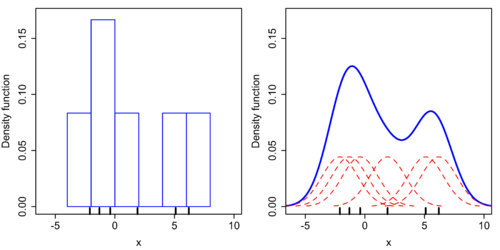

One common example of kernel is a normal kernel but also other functions can be used such as triangular, Epanechnikov or uniform.<br>

Here we can see how the *bandwidth* works.

In [ ]:
feats = ["age", "ejection_fraction", "serum_creatinine", "serum_sodium"]

fig, axs = plt.subplots(1, 4)
fig.set_size_inches(14, 4);

for j, ax in enumerate(axs):
    ax.set_title(feats[j], fontsize=13)
    sns.distplot(hf_norm.loc[hf["DEATH_EVENT"]==0, feats[j]], ax=ax, label="alive", color = "#990303", kde=False, rug=True)
    sns.distplot(hf_norm.loc[hf["DEATH_EVENT"]==1, feats[j]], ax=ax, label="dead", color = "#292323", kde=False, rug=True)
    ax.legend(prop={'size': 13})
    
fig.tight_layout()

In [ ]:
%matplotlib notebook
plt.ioff()
fig, axs = plt.subplots(1, 4);
%matplotlib inline 
plt.ion()

bws = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
feats = ["age", "ejection_fraction", "serum_creatinine", "serum_sodium"]
ylims = [0.8, 1, 1.75, 0.9]

fig.set_size_inches(14, 4);
def animate_func(i):    
    for j, ax in enumerate(axs):        
        ax.clear()        
        ax.set_ylim(0, ylims[j])
        sns.kdeplot(hf_norm.loc[hf["DEATH_EVENT"]==0, feats[j]], ax=ax,
                label="alive", color = "#990303", shade=True, kernel="gau", cut=0, bw=bws[i])
        sns.kdeplot(hf_norm.loc[hf["DEATH_EVENT"]==1, feats[j]], ax=ax,
                label="dead",  color = "#292323", shade=True, kernel="gau", cut=0, bw=bws[i])
        ax.set_xlabel(f"bandwidth: {bws[i]}")
        ax.set_title(feats[j])
        
    fig.tight_layout()
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(bws),
                               interval = 500, # in ms
                               );
HTML(anim.to_jshtml())

#### Bandwidth rule of thumb
There is also a rule of thumb for the selection of the best bandwidth in the case of **gaussian kernel** and **gaussian estimated distribution**.<br>

\begin{align}
h = \bigg(\frac{4 \hat\sigma^5}{3n}\bigg)^{\frac{1}{5}} \approx 1.06\hat\sigma n ^ {-\frac{1}{n}}
\end{align}

Even if gaussian assumptions seems to be [not respected](#normality_assumptions) we can see the results for our features:

In [ ]:
rot = lambda s: 1.06*np.std(s)*len(s)**(-0.2)

feats = ["age", "ejection_fraction", "serum_creatinine", "serum_sodium", "CPK"]

for feat in feats:
    
    h = rot(hf_norm.loc[hf["DEATH_EVENT"]==0, feat])
    print(f"{feat}: {np.round(h, 2)}")

Despite the rule of thumb, different bandwidths will be evaluated.

In [ ]:
from scipy.stats import gaussian_kde, norm

class bernoulli:  
    prob0, prob1 = None, None
    
    def __init__(self, samples):
        if isinstance(samples, list):
            if len(set(samples))!=2:
                print("not binary")
                return None
            
            counts = np.unique(samples, return_counts=True)
            self.prob0 = counts[1][0]/len(samples)
            self.prob1 = 1-self.prob0            
        else:
            if isinstance(samples, float):     
                self.prob1 = samples
                self.prob0 = 1-self.prob1

    def evaluate(self, x):
        if x==0:
            return self.prob0
        if x==1:
            return self.prob1
        return None
    
class MyNaiveBayes:  
    prior = None
    categorical = []
    distributions = {}
    columns = []
    
    def __init__(self, prior, categorical, bw=None):
        self.prior=bernoulli(prior)
        self.categorical = categorical
        
        if bw is not None:
            self.bw = bw
        else:
            self.bw="scott"
        
    def fit(self, X, y):
        self.columns = list(X.columns)
        
        for i, col in enumerate(self.columns):
            data = X[col]
            
            if(self.categorical[i]):
                distr0 = bernoulli(list(data[y==0]))
                distr1 = bernoulli(list(data[y==1]))
            else:
                distr0 = gaussian_kde(data[y==0], bw_method=self.bw)
                distr1 = gaussian_kde(data[y==1], bw_method=self.bw)
            
            self.distributions[col] = (distr0, distr1)
    
    def predict_proba(self, X):
        probs = []
        
        for _, sample in X.iterrows():
            score0 = 1
            score1 = 1
            
            for col in self.columns:
                score0 *= self.distributions[col][0].evaluate(sample[col])
                score1 *= self.distributions[col][1].evaluate(sample[col])

            score0 *= self.prior.evaluate(0)
            score1 *= self.prior.evaluate(1)
            
            prob1 = score1/(score0+score1)        
            probs.append(prob1)
            
        return np.array(probs)
     
    def predict(self, X):
        probs = self.predict_proba(X)
        probs[probs>=0.5] = 1
        probs[probs<0.5] = 0
        return probs

<a id='naive_bayes_with_KDE_and_bernoulli'></a>
### Naive bayes with KDE and bernoulli (Flexible bayes)

As stated before, the conditional distributions are a mix of **bernoulli and kde estimations**.<br>
The probabilities are then multiplied to obtain the class probability given the sample.

Here it's possible to see how the metrics change according the prior (on X axis) and bandwidth (on the slider).<br>
On the top left plot there is an example of a normal kernel (centered in zero) with the given bandwidth.

In [ ]:
gauss = norm(0, 1)
prior = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

no_rs_acc, no_rs_pre, no_rs_rec, no_rs_f1= [], [], [], []
rs_acc, rs_pre, rs_rec, rs_f1= [], [], [], []
sm_acc, sm_pre, sm_rec, sm_f1= [], [], [], []

for i in range(len(bws)):
    # original
    for p in prior:
        nb = MyNaiveBayes(prior = p, categorical=(True, True, False, False, False, False, False, False), bw=bws[i])
        nb.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])
        preds = nb.predict(ho_val_df[all_features])

        no_rs_acc.append(accuracy_score(preds, ho_val_df['DEATH_EVENT']))
        no_rs_pre.append(precision_score(preds, ho_val_df['DEATH_EVENT']))
        no_rs_rec.append(recall_score(preds, ho_val_df['DEATH_EVENT']))
        no_rs_f1.append(f1_score(preds, ho_val_df['DEATH_EVENT']))

    # oversampling
    for p in prior:
        nb = MyNaiveBayes(prior = p, categorical=(True, True, False, False, False, False, False, False), bw=bws[i])
        nb.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])
        preds = nb.predict(ho_val_df[all_features])

        rs_acc.append(accuracy_score(preds, ho_val_df['DEATH_EVENT']))
        rs_pre.append(precision_score(preds, ho_val_df['DEATH_EVENT']))
        rs_rec.append(recall_score(preds, ho_val_df['DEATH_EVENT']))
        rs_f1.append(f1_score(preds, ho_val_df['DEATH_EVENT']))

    # SMOTE
    for p in prior:
        nb = MyNaiveBayes(prior = p, categorical=(True, True, False, False, False, False, False, False), bw=bws[i])
        nb.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT'])
        preds = nb.predict(ho_val_df[all_features])

        sm_acc.append(accuracy_score(preds, ho_val_df['DEATH_EVENT']))
        sm_pre.append(precision_score(preds, ho_val_df['DEATH_EVENT']))
        sm_rec.append(recall_score(preds, ho_val_df['DEATH_EVENT']))
        sm_f1.append(f1_score(preds, ho_val_df['DEATH_EVENT']))     

In [ ]:
#sorted([(a, b) for a,b in zip(sm_acc, sm_f1)], key=lambda a: a[0]+a[1])

In [ ]:
print("K-Fold cross-validation metrics (5 folds)")
%matplotlib notebook
plt.ioff()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2);
%matplotlib inline 
plt.ion()

fig.set_size_inches(7, 7);
def animate_func(i):

    x = np.linspace(-3, 3, 1000)
    y = (gauss.pdf(x/bws[i]))/bws[i]
    
    ax1.clear()
    ax1.set_title("Gaussian kernel")
    ax1.plot(x, y, color='#990303', linewidth=1.5, label=f"bandwidth={bws[i]}")
    ax1.fill_between(x, 0, y, alpha=0.15, color='#990303')
    ax1.set_ylim(0, 4.1)
    ax1.set_xlim(-3.5, 3.5)
    ax1.legend(loc=1, fontsize=8)
    
    # original
    acc, pre, rec, f1= [], [], [], []
    for p in prior:
        nb = MyNaiveBayes(prior = p, categorical=(True, True, False, False, False, False, False), bw=bws[i])
        accuracy, precision, recall, f1_s = kfold.fit_predict(nb, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling=None)
        acc.append(accuracy)
        pre.append(precision)
        rec.append(recall)
        f1.append(f1_s)
        
    ax2.clear()
    ax2.set_ylim(0, 1)
    ax2.set_title("Original")
    ax2.set_xlabel("Prior class probability P(DEATH_EVENT=1)")
    
    ax2.plot(list(prior), acc, label="accuracy", marker='o', linewidth=2)
    ax2.plot(list(prior), pre, label="precision", marker='o', linewidth=1, alpha=0.5)
    ax2.plot(list(prior), rec, label="recall", marker='o', linewidth=1, alpha=0.5)
    ax2.plot(list(prior), f1, label="f1 score", marker='o', linewidth=1)
    ax2.legend(loc=4, fontsize=8)
    ax2.grid()

    # oversampling
    acc, pre, rec, f1= [], [], [], []
    for p in prior:
        nb = MyNaiveBayes(prior = p, categorical=(True, True, False, False, False, False, False), bw=bws[i])
        
        accuracy, precision, recall, f1_s = kfold.fit_predict(nb, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="oversampling")
        acc.append(accuracy)
        pre.append(precision)
        rec.append(recall)
        f1.append(f1_s)
        
    ax3.clear()
    ax3.set_ylim(0, 1)
    ax3.set_title("Random oversampling")
    ax3.set_xlabel("Prior class probability P(DEATH_EVENT=1)")
    
    ax3.plot(list(prior), acc, label="accuracy", marker='o', linewidth=2)
    ax3.plot(list(prior), pre, label="precision", marker='o', linewidth=1, alpha=0.5)
    ax3.plot(list(prior), rec, label="recall", marker='o', linewidth=1, alpha=0.5)
    ax3.plot(list(prior), f1, label="f1 score", marker='o', linewidth=1)
    ax3.legend(loc=4, fontsize=8)
    ax3.grid()

    # smote
    acc, pre, rec, f1= [], [], [], []
    for p in prior:
        nb = MyNaiveBayes(prior = p, categorical=(True, True, False, False, False, False, False), bw=bws[i])
        
        accuracy, precision, recall, f1_s = kfold.fit_predict(nb, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="SMOTE", cached="True")
        acc.append(accuracy)
        pre.append(precision)
        rec.append(recall)
        f1.append(f1_s)
        
    ax4.clear()
    ax4.set_ylim(0, 1)
    ax4.set_title("SMOTE")
    ax4.set_xlabel("Prior class probability P(DEATH_EVENT=1)")
    
    ax4.plot(list(prior), acc, label="accuracy", marker='o', linewidth=2)
    ax4.plot(list(prior), pre, label="precision", marker='o', linewidth=1, alpha=0.5)
    ax4.plot(list(prior), rec, label="recall", marker='o', linewidth=1, alpha=0.5)
    ax4.plot(list(prior), f1, label="f1 score", marker='o', linewidth=1)
    ax4.legend(loc=4, fontsize=8)
    ax4.grid()
    
    fig.tight_layout()
    return [fig]
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(bws),
                               interval = 500, # in ms
                               );
HTML(anim.to_jshtml())

In [ ]:
#sorted([(a, b) for a,b in zip(sm_acc, sm_f1)], key=lambda a: a[0]+a[1])

<a id='Gaussian_naive_bayes'></a>
### Gaussian Naive Bayes
Anyway, even if the hypothesis seems to be not respected, a Gaussian Naive Bayes is performed.<br>
In the Gaussian Naive Bayes we assume that our continouos values associated with the class are distributed according to a normal distribution.

\begin{align}
p(X_i=x_i|C = k) = \frac{1}{\sqrt{2\pi\sigma_{k}^{2}}} e^{-\frac{(x_i-\mu_k)^2}{2\sigma_k^2}}
\end{align}
where $x_i$ is the observation value and $\mu_k$ and $\sigma_k^2$ are respectively the sample mean and sample variance of the values in $X_i$ associated with class $k$.

As we can see, the results are still quite comparable with the other models.<br>
In fact one very nice positive aspect of Naive Bayes in general is the good performances even in cases in which some of the hypothesis are not respected.

In [ ]:
# original
no_rs_acc, no_rs_pre, no_rs_rec, no_rs_f1= [], [], [], []
for p in prior:
    nb = GaussianNB(priors=[1-p, p])
    nb.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])
    preds = nb.predict(ho_val_df[all_features])
    no_rs_acc.append(accuracy_score(preds, ho_val_df['DEATH_EVENT']))
    no_rs_pre.append(precision_score(preds, ho_val_df['DEATH_EVENT']))
    no_rs_rec.append(recall_score(preds, ho_val_df['DEATH_EVENT']))
    no_rs_f1.append(f1_score(preds, ho_val_df['DEATH_EVENT']))
    

# oversampling
rs_acc, rs_pre, rs_rec, rs_f1= [], [], [], []
for p in prior:
    nb = GaussianNB(priors=[1-p, p])
    nb.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])
    preds = nb.predict(ho_val_df[all_features])
    rs_acc.append(accuracy_score(preds, ho_val_df['DEATH_EVENT']))
    rs_pre.append(precision_score(preds, ho_val_df['DEATH_EVENT']))
    rs_rec.append(recall_score(preds, ho_val_df['DEATH_EVENT']))
    rs_f1.append(f1_score(preds, ho_val_df['DEATH_EVENT']))

# smote
sm_acc, sm_pre, sm_rec, sm_f1= [], [], [], []
for p in prior:
    nb = GaussianNB(priors=[1-p, p])
    nb.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT'])
    preds = nb.predict(ho_val_df[all_features])
    sm_acc.append(accuracy_score(preds, ho_val_df['DEATH_EVENT']))
    sm_pre.append(precision_score(preds, ho_val_df['DEATH_EVENT']))
    sm_rec.append(recall_score(preds, ho_val_df['DEATH_EVENT']))
    sm_f1.append(f1_score(preds, ho_val_df['DEATH_EVENT']))

In [ ]:
#sorted([(a, b) for a,b in zip(sm_acc, sm_f1)], key=lambda a: a[0]+a[1])

In [ ]:
# k fold
print("K-Fold cross-validation metrics (5 folds)")

plt.figure(figsize=(12, 4))

# original
acc, pre, rec, f1= [], [], [], []
    
for p in prior:
    nb = GaussianNB(priors=[1-p, p])
    accuracy, precision, recall, f1_s = kfold.fit_predict(nb, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling=None)
    acc.append(accuracy)
    pre.append(precision)
    rec.append(recall)
    f1.append(f1_s)
    
plt.subplot(1, 3, 1)
plt.ylim(0, 1)
plt.title("Original")
plt.xlabel("Prior class probability P(DEATH_EVENT=1)")
    
plt.plot(list(prior), acc, label="accuracy", marker='o', linewidth=2)
plt.plot(list(prior), pre, label="precision", marker='o', linewidth=1, alpha=0.5)
plt.plot(list(prior), rec, label="recall", marker='o', linewidth=1, alpha=0.5)
plt.plot(list(prior), f1, label="f1 score", marker='o', linewidth=1)
plt.legend()
plt.grid()

# oversampling
acc, pre, rec, f1= [], [], [], []
    
for p in prior:
    nb = GaussianNB(priors=[1-p, p])
    accuracy, precision, recall, f1_s = kfold.fit_predict(nb, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="oversampling")
    acc.append(accuracy)
    pre.append(precision)
    rec.append(recall)
    f1.append(f1_s)
    
plt.subplot(1, 3, 2)
plt.ylim(0, 1)
plt.title("Random oversampling")
plt.xlabel("Prior class probability P(DEATH_EVENT=1)")
    
plt.plot(list(prior), acc, label="accuracy", marker='o', linewidth=2)
plt.plot(list(prior), pre, label="precision", marker='o', linewidth=1, alpha=0.5)
plt.plot(list(prior), rec, label="recall", marker='o', linewidth=1, alpha=0.5)
plt.plot(list(prior), f1, label="f1 score", marker='o', linewidth=1)
plt.legend()
plt.grid()

# smote
acc, pre, rec, f1= [], [], [], []
    
for p in prior:
    nb = GaussianNB(priors=[1-p, p])
    accuracy, precision, recall, f1_s = kfold.fit_predict(nb, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="SMOTE", cached=True)
    acc.append(accuracy)
    pre.append(precision)
    rec.append(recall)
    f1.append(f1_s)

plt.subplot(1, 3, 3)
plt.ylim(0, 1)
plt.title("SMOTE")
plt.xlabel("Prior class probability P(DEATH_EVENT=1)")
    
plt.plot(list(prior), acc, label="accuracy", marker='o', linewidth=2)
plt.plot(list(prior), pre, label="precision", marker='o', linewidth=1, alpha=0.5)
plt.plot(list(prior), rec, label="recall", marker='o', linewidth=1, alpha=0.5)
plt.plot(list(prior), f1, label="f1 score", marker='o', linewidth=1)
plt.legend()
plt.grid()

plt.tight_layout()

In [ ]:
no_rs_acc, no_rs_pre, no_rs_rec, no_rs_f1= [], [], [], []
rs_acc, rs_pre, rs_rec, rs_f1= [], [], [], []
sm_acc, sm_pre, sm_rec, sm_f1= [], [], [], []


# original
for p in prior:
    nb = GaussianNB(priors=[1-p, p])
    accuracy, precision, recall, f1_s = kfold.fit_predict(nb, ho_train_df, ho_train_df['DEATH_EVENT'],
                                              threshold=0.5, resampling=None)
    no_rs_acc.append(accuracy)
    no_rs_pre.append(precision)
    no_rs_rec.append(recall)
    no_rs_f1.append(f1_s)

    # oversampling
for p in prior:
        nb = GaussianNB(priors=[1-p, p])

        accuracy, precision, recall, f1_s = kfold.fit_predict(nb, ho_train_df, ho_train_df['DEATH_EVENT'],
                                              threshold=0.5, resampling="oversampling")
        rs_acc.append(accuracy)
        rs_pre.append(precision)
        rs_rec.append(recall)
        rs_f1.append(f1_s)

        # smote
for p in prior:
        nb = GaussianNB(priors=[1-p, p])

        accuracy, precision, recall, f1_s = kfold.fit_predict(nb, ho_train_df, ho_train_df['DEATH_EVENT'],
                                              threshold=0.5, resampling="SMOTE", cached="True")
        sm_acc.append(accuracy)
        sm_pre.append(precision)
        sm_rec.append(recall)
        sm_f1.append(f1_s)


In [ ]:
#sorted([(a, b) for a,b in zip(sm_acc, sm_f1)], key=lambda a: a[0]+a[1])

<a id='Results_and_conclusions'></a>
# Results and conclusions <a style="text-decoration:none" href="#index">⤴</a>

Here we can see the results obtained with different models and different rebalancing techniques for the **Hearth Disease** dataset.<br>
Both **accuracy** and **f1 score** (inside parenthesis) are showed.

| Model  | Holdout Original | Holdout Oversampling | Holdout SMOTE | Holdout class-weight=balanced | KFold Original | KFold Oversampling | KFold SMOTE | KFold class-weight=balanced| 
| :------------- | :-------------: | :-------------: | :-------------: | :-------------: | :-------------: | :-------------: | :-------------: | :-------------: |
| **Decision Tree** | 0.706 (0.607) | 0.733 (0.655) | 0.706 (0.645) | 0.747 (0.698) | 0.790 (0.560) | 0.794 (0.687) | 0.754 (0.598) | 0.785 (0.664) | 
| **Random Forest** | 0.707 (0.577) | **0.787 (0.733)** | 0.747 (0.667) | 0.733 (0.642) | 0.803 (0.625) | **0.808 (0.683)** | 0.794 (0.654) | 0.799 (0.617) | 
| **Linear Regression** | 0.667 (0.444) | 0.693 (0.635) | 0.707 (0.633) | - | 0.776 (0.508) | 0.727 (0.611) | 0.750 (0.614) | - | 
| **Logistic Regression** | 0.667 (0.444) | 0.707 (0.645) | 0.733 (0.667) | 0.707 (0.645) | 0.772 (0.501) | 0.736 (0.607) | 0.759 (0.630) | 0.740 (0.619) | 
| **Linear SVM** | 0.653 (0.458) | 0.720 (0.667) | 0.720 (0.644) | 0.706 (0.656) | 0.736 (0.594) | 0.759 (0.606) | 0.781 (0.519) | 0.718 (0.574) | 
| **Poly SVM** | 0.680 (0.538) | 0.693 (0.582) | 0.640 (0.542) | 0.706 (0.607) | 0.759 (0.503) | 0.759 (0.562) | 0.763 (0.589) | 0.754 (0.536) | 
| **RBF SVM** | 0.680 (0.571) | 0.680 (0.657) | 0.720 (0.657) | 0.747 (0.698) | 0.790 (0.542) | 0.781 (0.669) | 0.794 (0.680) | **0.799 (0.693)** | 
| **KNN original** | 0.640 (0.501) | 0.720 (0.644) | 0.680 (0.586) | - | 0.772 (0.471) | 0.737 (0.603) | 0.763 (0.604) | - | 
| **KNN distance** | 0.667 (0.510) | 0.733 (0.667) | 0.793 (0.610) | - | 0.776 (0.485) | 0.737 (0.599) | 0.759 (0.601) | - | 
| **Flexible Bayes** | 0.733 (0.730) | 0.733 (0.714) | 0.747 (0.716) | - | 0.799 (0.631) | 0.772 (0.616) | 0.785 (0.611) | - | 
| **Gaussian Naive Bayes** | 0.693 (0.667) | 0.707 (0.686) | 0.733 (0.688) | - | 0.781 (0.653) | 0.763 (0.619) | 0.727 (0.606) | - | 

We can clearly see how using some rebalancing techniques the **f1 score** increase substancially.<br>
In some cases SMOTE performs better with respect to random oversampling, and the opposite in others.<br>
Furthermore, where is possible to apply it, also the use of the `class-weight` parameter increases the performances, sometimes outperforming the other techniques.

Then we noticed how using Gaussian Naive Bayes, even without respecting the hypothesis, leads to good results and also with a Bayes Classifier with KDE, the results are in line.

Best overall model seems to be the **random forest** trained on the oversampled dataset, that delivers the best results in terms of accuracy and f1 score.<br>
Also **RBF-SVM** with `class-weights=balanced` provides some good results on KFold.

For the models that allow it, it's possible to evaluate the **ROC curve** to select a threshold according to the main goal (minimize false positives or maximize true positives) but the results in the table are obtained by fixing the threshold at 0.5.

The overall results seem in line with the ones obtained in the reference paper [[1]](#references) but it's needed to keep in mind that the metrics are highly influenced by the small dimension of the dataset (75 samples in holdout validation set).

<a id='references'></a>
# References  <a style="text-decoration:none" href="#index">⤴</a>

[[1]](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5)  D. Chicco, G. Jurman. "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone", 2020


[[2]](https://arxiv.org/abs/1106.1813) N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer. SMOTE: Synthetic Minority Over-sampling Technique, 2002


[[3]](https://dl.acm.org/doi/10.5555/2074158.2074196) G. H. John, P. Langley. Estimating Continuous Distributions in Bayesian  Classifiers, 1995